In [1]:
#!/usr/bin/env python3

# add the path to the folder above, hardcoded
import sys
pathhere = "/home/luke/mujoco-devel/rl/"
sys.path.insert(0, pathhere)

from env.MjEnv import MjEnv
import numpy as np
from matplotlib import pyplot as plt
import pickle
from copy import deepcopy

# increase matplotlib resolution
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

# global variables
max_force = 3
set_name = "set9_testing"

# create and prepare the mujoco instance
mj = MjEnv()
mj.testing_xmls = 0
mj.task_reload_chance = -1

# specify finger dimensions
mj.params.finger_thickness = 0.9e-3
mj.params.finger_width = 28e-3

# additional settings to align with testing
mj.params.finger_modulus = 193e9
mj.params.finger_length = 230e-3
mj.params.segment_inertia_scaling = 50

rigidities = [0.29, 0.34, 0.40]

# 0=point end load, 1=UDL, 2=point end moment, 3=two point loads (end+midpoint)
force_style = 0

# BEWARE: SETTING PARAMS DOES NOT ACTUALLY LOAD THESE VALUES, FOR THAT USE mj.load_next.finger...

# specify youngs modulus (None = auto)
E = None

# # TESTING
# mj.mj.set_finger_modulus(193e9 * pow(1.0, 3)) # 190e9 gives <2.5% error for 0.9x28

# specify which segments to test
# segments = [5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
# segments = [5, 6, 7, 8, 9, 10]
# segments = [5, 10, 15]
segments = list(range(3, 31))
# segments = list(range(3, 6))

print(f"Finger thickness is {mj.params.finger_thickness * 1000:.1f} mm")
print(f"Finger width is {mj.params.finger_width * 1000:.1f} mm")

Finger thickness is 0.9 mm
Finger width is 28.0 mm


In [2]:
# will we recalculate data
get_data = False
use_converged = False

if False and not get_data:

  default_name_style = "sim_bending_E{0:.2f}_{1}.pickle"

  if force_style == 0: default_name_style += "_PL.pickle"
  elif force_style == 1: default_name_style += "_UDL.pickle"
  elif force_style == 2: default_name_style += "_EM.pickle"
  else: raise RuntimeError("no matching force_style")

  # load some existing data defaults, can be overwritten
  if (abs(mj.params.finger_thickness * 1000 - 0.8) < 1e-5 and
     abs(mj.load_finger_width * 1000 - 28) < 1e-5):
    finger_params = (0.8, 28)
    with open(default_name_style.format(0.8, 28), "rb") as f:
      d_0p8_28_model_default = pickle.load(f)
    data = d_0p8_28_model_default

  elif (abs(mj.params.finger_thickness * 1000 - 0.9) < 1e-5 and
     abs(mj.load_finger_width * 1000 - 24) < 1e-5):
    finger_params = (0.9, 24)
    with open(default_name_style.format(0.9, 24), "rb") as f:
      d_0p9_24_model_default = pickle.load(f)
    data = d_0p9_24_model_default

  elif (abs(mj.params.finger_thickness * 1000 - 0.9) < 1e-5 and
     abs(mj.load_finger_width * 1000 - 28) < 1e-5):
    finger_params = (0.9, 28)
    with open(default_name_style.format(0.9, 28), "rb") as f:
      d_0p9_28_model_default = pickle.load(f)
    data = d_0p9_28_model_default

  elif (abs(mj.params.finger_thickness * 1000 - 1.0) < 1e-5 and
     abs(mj.load_finger_width * 1000 - 24) < 1e-5):
    finger_params = (1.0, 24)
    with open(default_name_style.format(1.0, 24), "rb") as f:
      d_1p0_24_model_default = pickle.load(f)
    data = d_1p0_24_model_default

  elif (abs(mj.params.finger_thickness * 1000 - 1.0) < 1e-5 and
     abs(mj.load_finger_width * 1000 - 28) < 1e-5):
    finger_params = (1.0, 28)
    with open(default_name_style.format(1.0, 28), "rb") as f:
      d_1p0_28_model_default = pickle.load(f)
    data = d_1p0_28_model_default

  elif (abs(mj.params.finger_thickness * 1000 - 1.1) < 1e-5 and
     abs(mj.load_finger_width * 1000 - 24) < 1e-5):
    finger_params = (1.1, 24)
    with open(default_name_style.format(1.1, 24), "rb") as f:
      d_1p1_24_model_default = pickle.load(f)
    data = d_1p1_24_model_default

  else:
    raise RuntimeError("no finger thickness matches")


In [3]:
default_name_style = "sim_data/sim_bending_E{0:.2f}_{1}{2}.pickle"

save_suffix = "paper"

if not get_data:

  if force_style == 0: force_str = "PL"
  elif force_style == 1: force_str = "UDL"
  elif force_style == 2: force_str = "EM"
  elif force_style == 3: force_str = "2PL"
  else: raise RuntimeError("no matching force_style")

  # load some existing data defaults, can be overwritten
  if (abs(mj.params.finger_thickness * 1000 - 0.9) < 1e-5 and
     abs(mj.params.finger_width * 1000 - 28) < 1e-5):
    finger_params = (0.9, 28)
    with open(default_name_style.format(rigidities[0], force_str, save_suffix), "rb") as f:
      model_0p30 = pickle.load(f)
    data = model_0p30

  elif (abs(mj.params.finger_thickness * 1000 - 1.0) < 1e-5 and
     abs(mj.params.finger_width * 1000 - 24) < 1e-5):
    finger_params = (1.0, 24)
    with open(default_name_style.format(rigidities[1], force_str, save_suffix), "rb") as f:
      model_0p35 = pickle.load(f)
    data = model_0p35

  elif (abs(mj.params.finger_thickness * 1000 - 1.0) < 1e-5 and
     abs(mj.params.finger_width * 1000 - 28) < 1e-5):
    finger_params = (1.0, 28)
    with open(default_name_style.format(rigidities[2], force_str, save_suffix), "rb") as f:
      model_0p41 = pickle.load(f)
    data = model_0p41

  else:
    raise RuntimeError("no finger thickness matches")

In [4]:
with open("real_finger_data_curve_fit.pickle", "rb") as f:
  real_finger_data = pickle.load(f)

# check if we are running with a finger we have real data for
if finger_params == (0.9, 28):
  ind = 0
  fingernum = 3 # 3>2>1, 
elif finger_params == (1.0, 24):
  ind = 1
  fingernum = 3 # 1>3>2, 1&3 excellent, 2 poor (max ~10%, avg ~6%), 2 the 0g sample is clearly different from the others
elif finger_params == (1.0, 28):
  ind = 2
  fingernum = 2 # 2>1>3, 2 excellent, 1&3 poor (max ~8%, avg ~4%)
else:
  ind = None

num_fingers = 1
fingernum = 1 # only one datapoint

real_data = [ [ [] for i in range(num_fingers)] for j in range(3) ]

if ind is not None:
  for j in range(3):

    # # 3 entries, one for each finger we collected real data for
    # real_data = [ [] for i in range(3) ]

    for i in range(num_fingers):

      # get the raw profiles
      real_0g = real_finger_data[j][i][0]
      real_100g = real_finger_data[j][i][1]
      real_200g = real_finger_data[j][i][2]
      real_300g = real_finger_data[j][i][3]

      # # check the zero
      # # if real_100g[0, 0] < 0: real_100g[:, 0] -= real_100g[0, 0]
      # if j == 2 and i == 1:
      #   print(real_200g[:10, 0])
      #   print(real_200g[:10, 1])
      #   myslice = real_200g[:4]
      #   myslice = np.flip(myslice, axis=0)
      #   print(myslice)
      #   real_200g[:4] = myslice
      #   real_200g[:, 0] -= real_200g[0, 0]
      #   real_200g[:, 1] -= real_200g[0, 1]
      #   print(real_200g[:10])
      # # if real_300g[0, 0] < 0: real_300g[:, 0] -= real_300g[0, 0]

      # subract the 0g case from the other deflection
      diff_vec_100g = mj.mj.profile_error(real_100g[:,0], real_100g[:,1], real_0g[:,0], real_0g[:,1], False)
      diff_vec_200g = mj.mj.profile_error(real_200g[:,0], real_200g[:,1], real_0g[:,0], real_0g[:,1], False)
      diff_vec_300g = mj.mj.profile_error(real_300g[:,0], real_300g[:,1], real_0g[:,0], real_0g[:,1], False)

      # put in the subracted y values
      real_100g[:,1] = diff_vec_100g
      real_200g[:,1] = diff_vec_200g
      real_300g[:,1] = diff_vec_300g

      real_data_minus_0g = [
        real_100g,
        real_200g,
        real_300g,
      ]

      real_data[j][i] = real_data_minus_0g

else: real_data = None

In [5]:
def run_curve_data(mjenv, segments, auto=True, force_style=0, get_timesteps_only=False):
  """
  This function returns a data structure containing curve validation data for
  a given mjenv across a given list of segments eg [5, 10, 15, 20]
  """

  data = []

  # turn on automatic finding of highest stable timestep
  mjenv.mj.set.auto_set_timestep = auto

  # turn off automatic finding of calibrations as they are not needed
  mjenv.mj.set.auto_calibrate_gauges = False

  if get_timesteps_only:
    timesteps = []

  # loop through each object set and gather data
  for N in segments:

    mjenv.params.test_objects = 1
    mjenv.params.task_reload_chance = -1
    mjenv.load(num_segments=N)
    mjenv.reset(hard=True, nospawn=True)

    if get_timesteps_only:

      this_timestep = mjenv.mj.set.mujoco_timestep
      timesteps.append(this_timestep)
      print(f"Timestep for N = {N} is {this_timestep * 1000:.1f} ms")
      continue

    else:

      print("Curve validation running for N =", N, "\t N in sim is", mjenv.mj.get_N(), flush=True)
      print_out = False
      finger_data = mjenv.mj.curve_validation_regime(print_out, force_style)
      data.append(finger_data)

  if get_timesteps_only: return timesteps

  print(f"force style was {force_style}")

  return data

# set finger stiffness algorithm
finger_stiffness = -7.5 # finalised theory result

auto_timestep = True
converge = None
accuracy = None

# # uncomment to recalculate stiffnesses and converge
# converge = 3 * 0.981 # grams force, not newtons
# accuracy = 5e-4
# finger_stiffness = -7.5 # finalised theory as intial guess

if get_data:
  data = run_curve_data(mj, segments, set_name, auto=auto_timestep, stiffness=finger_stiffness, converge_to=converge, 
  converge_target_accuracy=accuracy, force_style=force_style)

# # test force style 3, where we have two point loads on the beam
# data = run_curve_data(mj, [3, 4, 5], auto=auto_timestep, force_style=force_style)


In [6]:
# get timestep information
if False:
  
  # comment this out if only want to mess with the graph
  timesteps_true = run_curve_data(mj, segments, set_name, auto=auto_timestep, stiffness=finger_stiffness, get_timesteps_only=True)
  timesteps_50i = run_curve_data(mj, segments, "set7_testing_50i", auto=auto_timestep, stiffness=finger_stiffness, get_timesteps_only=True)

  fig, ax = plt.subplots(1, 1)
  ax.plot(segments, 1e3 * np.array(timesteps_true), label="Normal fingers")
  ax.plot(segments, 1e3 * np.array(timesteps_50i), "--", label="50x inertia")
  ax.set(xlabel="Number of segments, N", ylabel="Mujoco timestep / ms")
  ax.set(ylim=[0, 6])
  ax.legend()


Max deflection at 100 grams is 13.889987953007221
Max deflection at 100 grams is 13.889987953007221
Max deflection at 100 grams is 13.889987953007221
Max deflection at 300 grams is 41.66996479034424
Max deflection at 300 grams is 41.66996479034424
Max deflection at 300 grams is 41.66996479034424


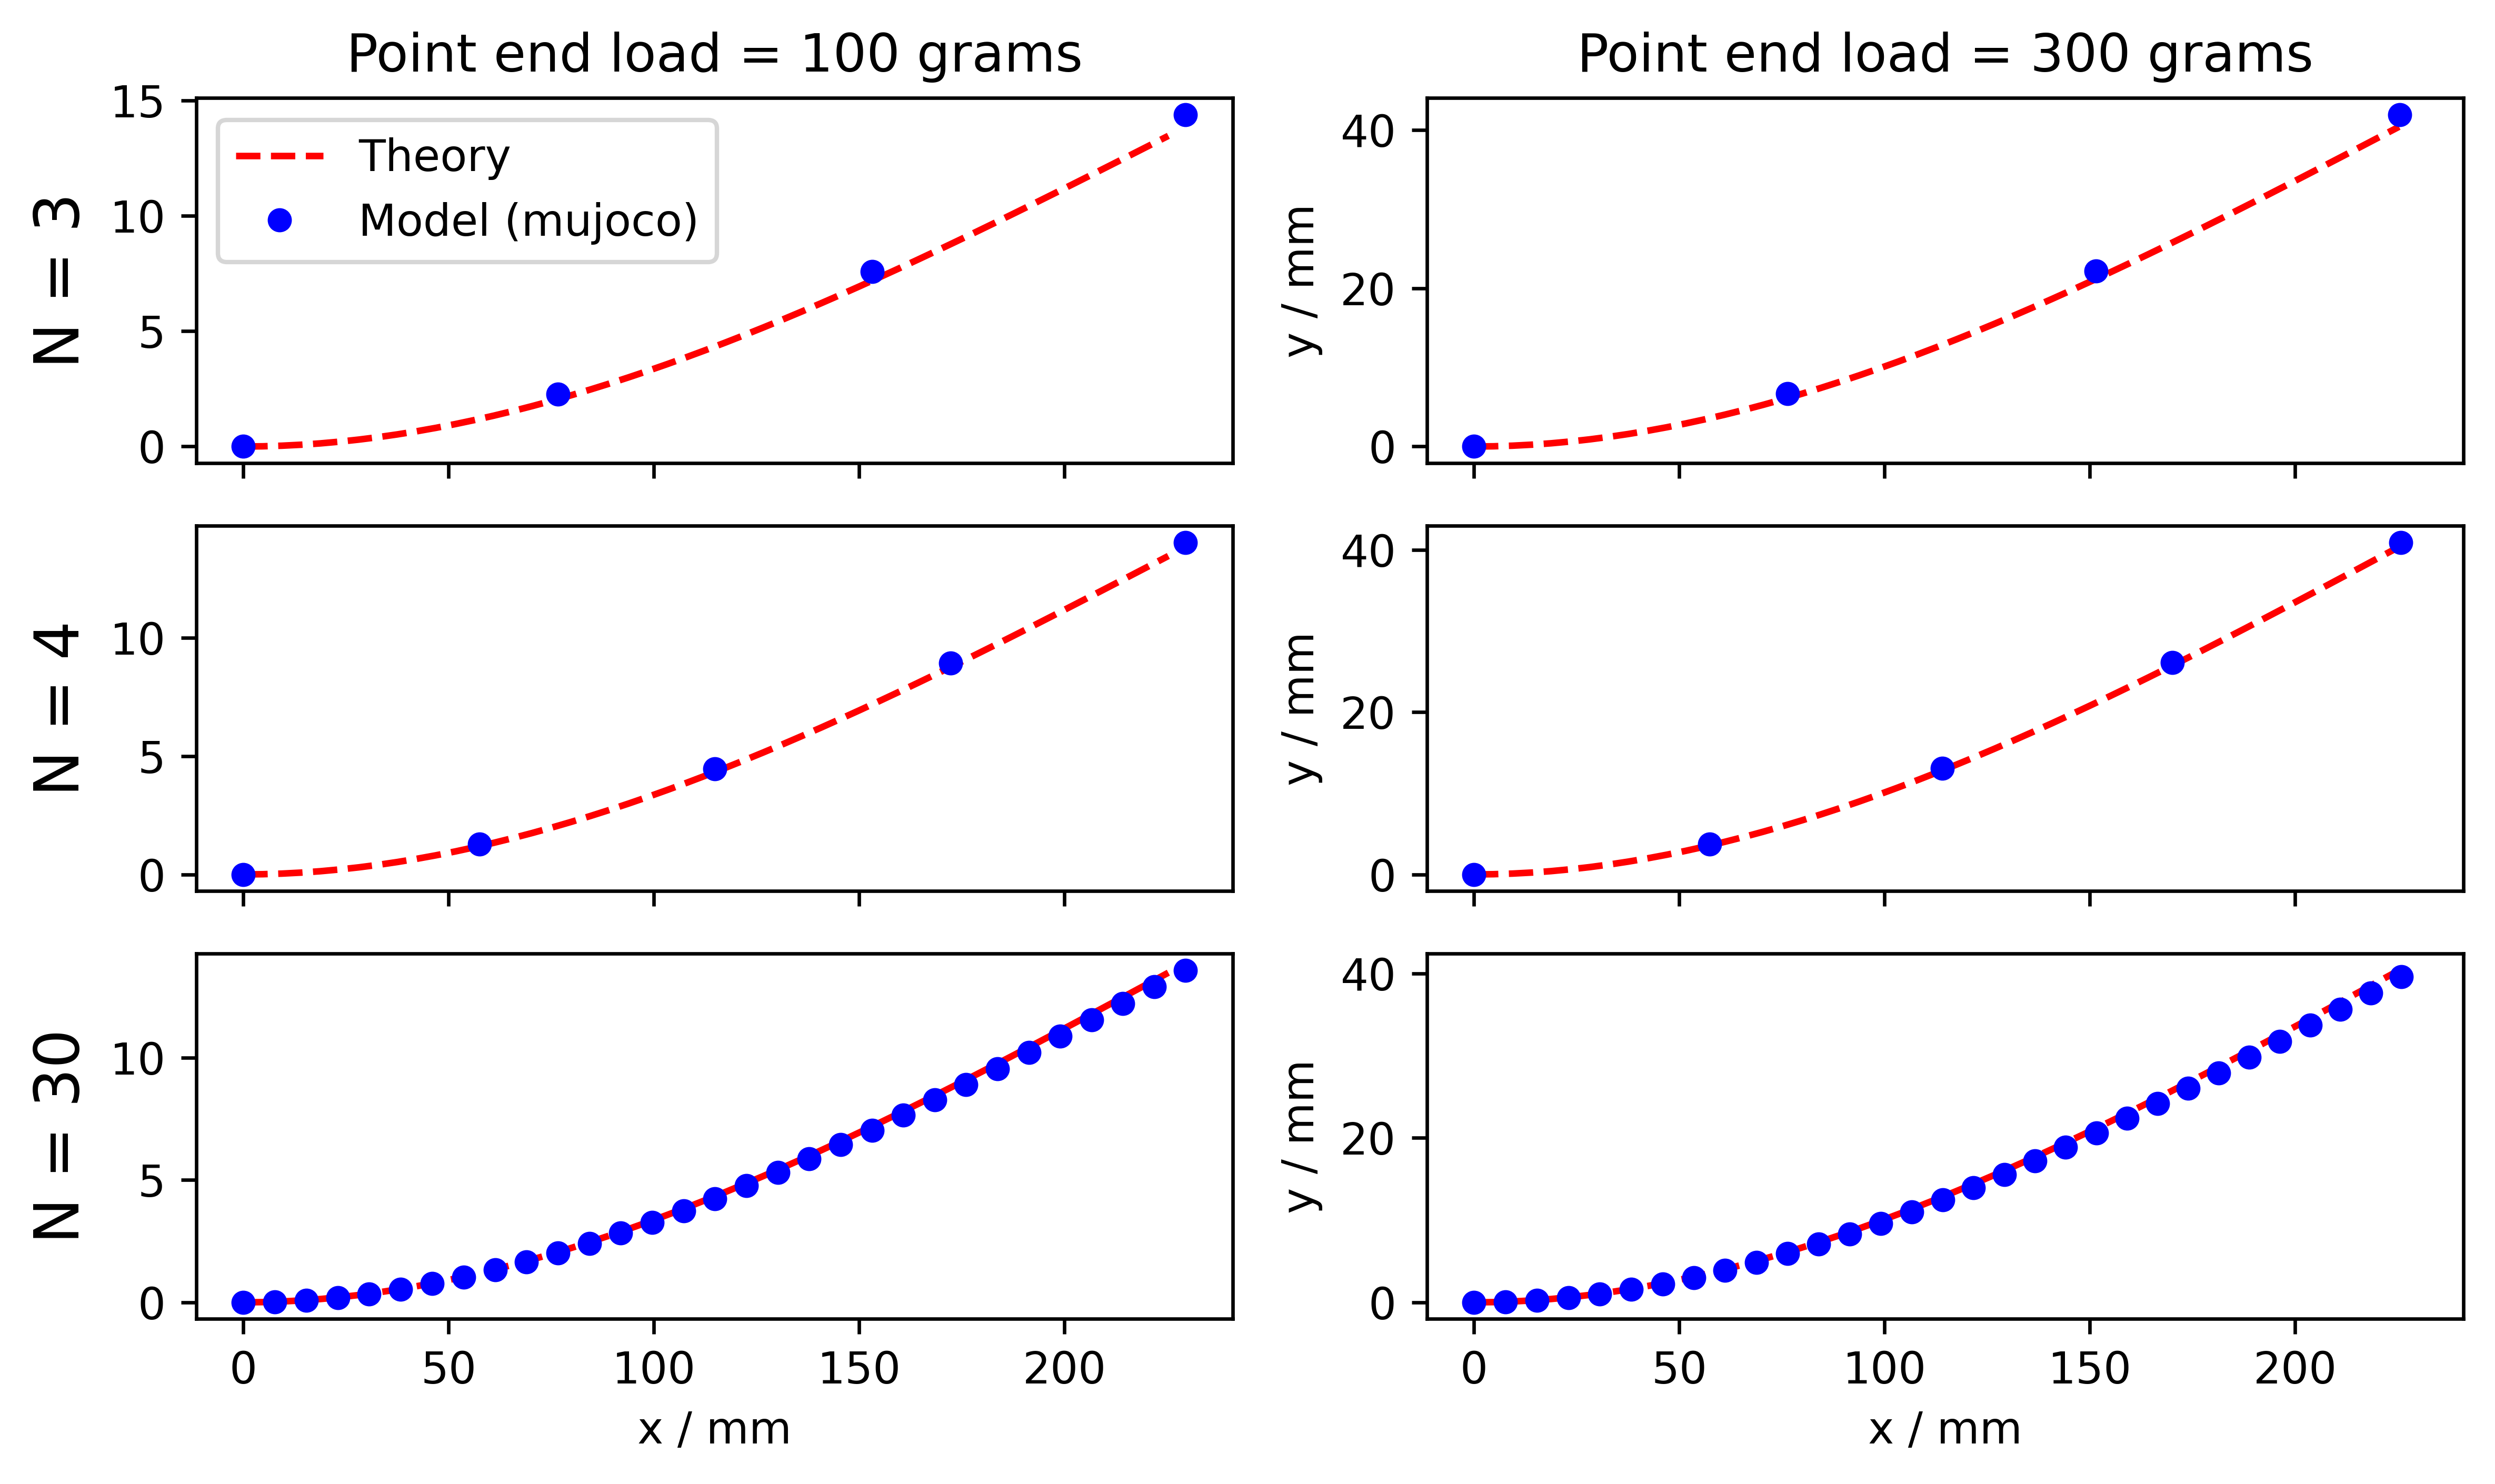

In [7]:
def plot_deflection(data, entries=None, pred=False, theory=True, FEA=None, real=None, forces=None, flip=False,
                    normalise=False, label_N=True):
  """
  Plot the XY beam deflection curves
  """
  
  num_sets = len(data)

  # process the data and plot it
  if entries is None:
    entries = [0, (num_sets // 2) - 2, -1]
    entries = [0, -1]
  elif entries == "all":
    entries = list(range(num_sets))
  plot_height = len(entries)

  if forces == "all":
    forces = list(range(1, max_force + 1))
  elif forces == "min":
    forces = [1]
  elif forces == "max":
    forces = [max_force]
  else:
    forces = [1, max_force]

  if force_style == 0: force_style_name = "Point end load"
  elif force_style == 1: force_style_name = "Uniform load"
  elif force_style == 2: force_style_name = "End momenet"
  elif force_style == 3: force_style_name = "2 point loads"
  else:
    raise RuntimeError(f"force_style of {force_style} not recognised")

  plot_width = len(forces)

  fig, axs = plt.subplots(len(entries), len(forces), sharex=True, sharey=False)
  
  if len(entries) == 1 and len(forces) == 1:
    axs = [[axs]]
  elif len(entries) == 1:
    axs = [axs]

  if flip: sign = -1
  else: sign = 1
  
  # # catch for case with only one plot
  # if len(forces) == 1: axs = [[axs[0], axs[0]], [axs[1], axs[1]]]

  for i, force in enumerate(forces):
    for j, ind in enumerate(entries):

      # lets start by plotting a basic example
      x =        1e3 * np.array(data[ind].entries[force - 1].f1.x)
      y =        sign * 1e3 * np.array(data[ind].entries[force - 1].f1.y)
      pred_x =   1e3 * np.array(data[ind].entries[force - 1].f1.pred_x)
      pred_y =   sign * 1e3 * np.array(data[ind].entries[force - 1].f1.pred_y)
      theory_x = 1e3 * np.array(data[ind].entries[force - 1].f1.theory_x_curve)
      theory_y = sign * 1e3 * np.array(data[ind].entries[force - 1].f1.theory_y_curve)
      if real is not None:
        real_x = deepcopy(real[force - 1][:, 0])
        real_y = deepcopy(sign * real[force - 1][:, 1])

      if normalise:
        factor = (1 / mj.params.finger_length) * 1e-3
        x = x * factor
        y = y * factor
        pred_x = pred_x * factor
        pred_y = pred_y * factor
        theory_x = theory_x * factor
        theory_y = theory_y * factor
        if real is not None:
          real_x = real_x * factor
          real_y = real_y * factor


      if pred is True:
        axs[j][i].plot(pred_x,   pred_y,   "r--*", label="model predictions")
      if theory is True:
        axs[j][i].plot(theory_x[:-1], theory_y[:-1], "r--", label="Theory")
      if FEA is not None:
        axs[j][i].plot(FEA[force - 1][:,0], FEA[force - 1][:,1], label="FEA")
      if real is not None:
        axs[j][i].plot(real_x, real_y, "g", label="Real data")

        # always plot the mujoco curve
      axs[j][i].plot(x,        y,        "bo",  label="Model (mujoco)", markersize=4.5)

      # add error labelling, not currently wanted
      # axs[j][i].text(0.005, data[ind].entries[force - 1].f1.theory_y[-1] * 0.4,
      #   f"mujoco stddev wrt model= {1000 * data[ind].entries[force - 1].f1.error.std_y_wrt_pred_y:.2f}mm\n" +
      #   f"mujoco stddev wrt theory = {1000 * data[ind].entries[force - 1].f1.error.std_y_wrt_theory_y:.2f}mm\n" +
      #   f"model stddev wrt theory = {1000 * data[ind].entries[force - 1].f1.error.std_y_pred_wrt_theory_y:.2f}mm",
      #   fontsize=14)

      # adjusting axis settings
      # axs[j][i].axis("equal")
      # axs[j][i].legend(loc="upper left", fontsize=9)
      # axs[j][i].set(ylim=(0, 60e-3))
      
      # add axis labels
      if normalise:
        xlabel = "a/L"
        ylabel = "b/L"
      else:
        xlabel = "x / mm"
        ylabel = "y / mm"
      axs[j][i].set(ylabel=ylabel)
      if j == len(entries) - 1:
        axs[j][i].set(xlabel=xlabel)
      if j == 0 and len(forces) != 1:
        axs[j][i].set_title(f"{force_style_name} = {force * 100} grams", fontsize=12)
        # axs[j][i].set_title(f"{force * 100} grams", fontsize=20)
      if i == 0:
        temp_N = len(data[ind].entries[force - 1].f1.y) - 1
        if label_N: axs[j][i].set_ylabel(f"N = {temp_N}", fontsize=14, rotation=90)

      print(f"Max deflection at {force * 100} grams is", theory_y[-1])

  if flip: loc = "lower left"
  else: loc = "upper left"
  axs[0][0].legend(loc=loc, fontsize=10)
  tile_height = 1.6 + 0.5 * (len(entries) == 1)
  tile_width = 4
  fig.set_size_inches(tile_width*plot_width, tile_height*plot_height)

  # potential size overrides
  # fig.set_size_inches(12, 5)
  # fig.set_size_inches(10, 5)

  fig.tight_layout()

# # now run the above function and plot the deflection curves
# plot_deflection(data, entries=[0,12,-1], pred=False, theory=True, real=real_data[ind][fingernum - 1])

# # single plot of N=8
# plot_deflection(data, entries=[5], pred=False, theory=True, real=real_data[ind][fingernum - 1], 
#                 flip=True, forces="max", normalise=True, label_N=False)

plot_deflection(data, entries=[0, 1, -1], pred=False, theory=True)

# print(real_data[ind][fingernum - 1][1])

In [8]:
def plot_errors(datainput, plot=None, y_vs_pred=True, y_vs_theory=True, pred_vs_theory=True,
                percent=False, j_vs_pred=False, absolute_error=True, plot_avg=False,
                sharey=False, plot_zero=True, all_loads_plot=False, titles_override=None,
                real_data=None):
  """
  Plot an error curve
  """

  if real_data is not None: y_vs_real = True
  else: y_vs_real = False

  num_plots = y_vs_pred + y_vs_theory + pred_vs_theory + j_vs_pred + y_vs_real
  fig_labels = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) "]

  if all_loads_plot: num_plots += len(datainput) - 1

  fig, axs = plt.subplots(1, num_plots, sharey=sharey)

  if num_plots == 1:
    axs = [axs]

  p = -1 # plot counter
  axis_label = True

  if all_loads_plot: loop_over = datainput
  else: loop_over = [datainput]

  for data in loop_over:

    num_sets = len(data)
    labels = ["100g", "200g", "300g", "400g"]
    if plot_avg: labels += ["avg."]
    unit = "mm" if not percent else "%"

    # redefine forces and entries to include all, otherwise index error
    forces = list(range(1, max_force + 1))

    # prepare to get error data
    y_wrt_pred_y = np.zeros((num_sets, len(forces)))
    y_wrt_theory_y = np.zeros((num_sets, len(forces)))
    y_pred_wrt_theory_y = np.zeros((num_sets, len(forces)))
    j_wrt_pred_j = np.zeros((num_sets, len(forces)))
    y_wrt_real = np.zeros((num_sets, len(forces)))

    sets_N = []

    for i in range(num_sets):

      sets_N.append(len(data[i].entries[0].f1.y) - 1)

      for j in range(len(forces)):

        if plot == "joints":
          # joint error in millimeters
          if percent:
            y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_wrt_pred_y_percent * 100
            y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_wrt_theory_y_percent * 100
            y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_pred_wrt_theory_y_percent * 100
            j_wrt_pred_j[i, j] = data[i].entries[forces[j] - 1].f1.error.j_wrt_pred_j_percent * 100
          else:
            y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_wrt_pred_y * 1000
            y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_wrt_theory_y * 1000
            y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_pred_wrt_theory_y * 1000
            j_wrt_pred_j[i, j] = data[i].entries[forces[j] - 1].f1.error.j_wrt_pred_j * 1000
        elif plot == "tip":
          # Tip y error percentage
          if percent:
            y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_pred_y_percent * 100
            y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_theory_y_percent * 100
            y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_pred_tip_wrt_theory_y_percent * 100
          else:
            y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_pred_y * 1000
            y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_theory_y * 1000
            y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_pred_tip_wrt_theory_y * 1000

        # are we plotting error wrt to real data
        if y_vs_real:
          # get the profile error for each of our model joint positions
          relative = percent # relative error is % but not *100 eg 0.1 not 10%
          # convert mm to metres
          real_data_SI = real_data[forces[j] - 1] * 1.0e-3
          profile_error = mj.mj.profile_error(
            data[i].entries[forces[j] - 1].f1.x,
            data[i].entries[forces[j] - 1].f1.y,
            real_data_SI[:, 0],
            real_data_SI[:, 1],
            relative
          )
          profile_error = np.abs(profile_error)
          # determine the average joint/tip error
          factor = 100 if relative else 1000
          if plot == "joints":
            y_wrt_real[i, j] = np.mean(np.array(profile_error)) * factor
          elif plot == "tip":
            y_wrt_real[i, j] = profile_error[-1] * factor

    # do we convert to absolute error
    if absolute_error:
      y_wrt_pred_y = np.abs(y_wrt_pred_y)
      y_wrt_theory_y = np.abs(y_wrt_theory_y)
      y_pred_wrt_theory_y = np.abs(y_pred_wrt_theory_y)
      j_wrt_pred_j = np.abs(j_wrt_pred_j)
      y_wrt_real = np.abs(y_wrt_real)
    
    # get the mean error
    mean_y_wrt_pred_y = np.mean(y_wrt_pred_y, axis=1)
    mean_y_wrt_theory_y = np.mean(y_wrt_theory_y, axis=1)
    mean_y_pred_wrt_theory_y = np.mean(y_pred_wrt_theory_y, axis=1)
    mean_j_wrt_pred_j = np.mean(j_wrt_pred_j, axis=1)
    mean_y_wrt_real = np.mean(y_wrt_real, axis=1)

    lines = '-'
    avg = '--' # line style for average of all other lines
    zero = 'k:'

    if pred_vs_theory:
      p += 1
      axs[p].plot(np.array(sets_N), y_pred_wrt_theory_y, lines)
      if plot_avg: axs[p].plot(np.array(sets_N), mean_y_pred_wrt_theory_y, avg)
      if plot_zero: axs[p].plot(np.array(sets_N), np.zeros(len(sets_N)), zero)
      axs[p].set_title(fig_labels[p] + ("Model prediction error" if titles_override is None else titles_override[p]))
      axs[p].set(xlabel="Number of segments, N")
      if axis_label:
        if plot == "joints": axs[p].set(ylabel=f"Average joint y error / {unit}")
        if plot == "tip": axs[p].set(ylabel=f"Tip y error / {unit}")
        if sharey: axis_label = False

    if y_vs_pred:
      p += 1
      axs[p].plot(np.array(sets_N), y_wrt_pred_y, lines)
      if plot_avg: axs[p].plot(np.array(sets_N), mean_y_wrt_pred_y, avg)
      if plot_zero: axs[p].plot(np.array(sets_N), np.zeros(len(sets_N)), zero)
      axs[p].set_title(fig_labels[p] + ("Actual error wrt prediction" if titles_override is None else titles_override[p]))
      axs[p].set(xlabel="Number of segments, N")
      if axis_label:
        if plot == "joints": axs[p].set(ylabel=f"Average joint y error / {unit}")
        if plot == "tip": axs[p].set(ylabel=f"Tip y error / {unit}")
        if sharey: axis_label = False

    if y_vs_theory:
      p += 1
      axs[p].plot(np.array(sets_N), y_wrt_theory_y, lines)
      if plot_avg: axs[p].plot(np.array(sets_N), mean_y_wrt_theory_y, avg)
      if plot_zero: axs[p].plot(np.array(sets_N), np.zeros(len(sets_N)), zero)
      axs[p].set_title(fig_labels[p] + ("Model actual error (mujoco)" if titles_override is None else titles_override[p]))
      axs[p].set(xlabel="Number of segments, N")
      if axis_label:
        if plot == "joints": axs[p].set(ylabel=f"Average joint y error / {unit}")
        if plot == "tip": axs[p].set(ylabel=f"Tip y error / {unit}")
        if sharey: axis_label = False

    if j_vs_pred and plot == "joints":
      p += 1
      axs[p].plot(np.array(sets_N), j_wrt_pred_j, lines)
      if plot_avg: axs[p].plot(np.array(sets_N), mean_j_wrt_pred_j, avg)
      if plot_zero: axs[p].plot(np.array(sets_N), np.zeros(len(sets_N)), zero)
      axs[p].set_title(fig_labels[p] + ("simulated joints wrt model" if titles_override is None else titles_override[p]))
      axs[p].set(xlabel="Number of segments, N")
      if axis_label:
        if plot == "joints": axs[p].set(ylabel=f"Average joint y error / {unit}")
        if plot == "tip": axs[p].set(ylabel=f"Tip y error / {unit}")
        if sharey: axis_label = False

    if y_vs_real:
      p += 1
      axs[p].plot(np.array(sets_N), y_wrt_real, lines)
      if plot_avg: axs[p].plot(np.array(sets_N), mean_y_wrt_real, avg)
      # TESTING - delete later
      print("Mean average error is", np.mean(mean_y_wrt_real))
      print("Mean maximum error is", np.mean(np.max(y_wrt_real, axis=1)))
      print("Max maximum error is", np.max(np.max(y_wrt_real, axis=1)))
      if plot_zero: axs[p].plot(np.array(sets_N), np.zeros(len(sets_N)), zero)
      axs[p].set_title(fig_labels[p] + ("Mujoco error vs real data" if titles_override is None else titles_override[p]))
      axs[p].set(xlabel="Number of segments, N")
      if axis_label:
        if plot == "joints": axs[p].set(ylabel=f"Average joint y error / {unit}")
        if plot == "tip": axs[p].set(ylabel=f"Tip y error / {unit}")
        if sharey: axis_label = False
        # if we can, remove the 400g label as there is no real data for it
        labels = ["100g", "200g", "300g"]
        if plot_avg: labels += ["avg."]

  # add legend and labels
  lines = axs[p].get_lines()
  plt.legend(iter(lines), labels, loc="center left", bbox_to_anchor=(1, 0.5))
  # if plot == "joints": axs[0].set(ylabel=f"Average joint y error / {unit}", xlabel="Number of segments, N")
  # if plot == "tip": axs[0].set(ylabel=f"Tip y error / {unit}", xlabel="Number of segments, N")
  # fig.suptitle("Joint displacement error against number of segments, N", fontsize=14)
  fig.tight_layout()
  # fig.subplots_adjust(top=0.8)

  fig.set_size_inches(3.5*num_plots, 3)

  return

# # run the above plotting function
# plot_errors(data, plot="joints", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=True, percent=False)
# plot_errors(data, plot="joints", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=True, percent=True)
# plot_errors(data, plot="tip", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=False, percent=False, sharey=True)
# plot_errors(data, plot="tip", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=False, percent=True, 
#             sharey=True, absolute_error=False, plot_avg=False)

# plot_errors(data, plot="joints", y_vs_pred=False, y_vs_theory=False, pred_vs_theory=False, j_vs_pred=True, percent=True)


# # test out real data error for all three fingers
# plot_errors(data, plot="tip", y_vs_pred=False, y_vs_theory=False, pred_vs_theory=False, 
#             percent=True, sharey=True, real_data=real_data[ind][0], plot_avg=True)
# plot_errors(data, plot="tip", y_vs_pred=False, y_vs_theory=False, pred_vs_theory=False, 
#             percent=True, sharey=True, real_data=real_data[ind][1], plot_avg=True)
# plot_errors(data, plot="tip", y_vs_pred=False, y_vs_theory=False, pred_vs_theory=False, 
#             percent=True, sharey=True, real_data=real_data[ind][2], plot_avg=True)


# plot_errors(data, plot="joints", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=False, 
#             percent=True, sharey=True, real_data=real_data_minus_0g)


In [9]:
if use_converged:
  
  auto_timestep = True

  # uncomment to recalculate stiffnesses and converge
  converge_force = 3 * 0.981 # 300 grams force
  finger_stiffness = -7.5 # finalised theory as intial guess
  accuracy = 5e-4

  # uncomment to use hardcoded stiffness values
  converge_force = None
  finger_stiffness = -101 # hardcoded theory predictions convergence
  accuracy = None

  data_converged = run_curve_data(mj, segments, converge_to=converge_force, auto=auto_timestep, 
                                  stiffness=finger_stiffness, force_style=force_style)

In [10]:
if use_converged:

  # generate plots with converged data
  plot_deflection(data_converged, entries=None, pred=False, theory=True) #, FEA=FEA_xy2, real=REAL_xy)
  plot_errors(data_converged, plot="joints", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=False, percent=True)
  plot_errors(data_converged, plot="tip", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=False, percent=True)

In [23]:
def plot_avg_errors(data_array, labels, titles=None, joint_plot=True, tip_plot=True, joint_percent=False,
                    tip_percent=True, difference_plot=False, sharey=False, prediction_plot=False,
                    absolute_error=True, multiplot_num=3, max_plot=False, max_error=False,
                    fill_errors=None, real_data=None, real_tip=True, area_error=False, k_print_max=True,
                    min_force=None, fingernums=[1, 1, 1], print_k=False, square_plot=False, grid=False,
                    plot_ylims=[0, 8], do_method_compare=False, average_all_theory=False):
  """
  Plot an error curve (old fingernums = 3,1,2)
  """

  if area_error and not joint_percent:
    print("WARNING: area_error=True but joint_percent=False, check as area_error is a percentage joint plot")

  if real_data is not None:
    real_error_plot = True
  else:
    real_error_plot = False

  num_plots = prediction_plot + joint_plot + tip_plot + difference_plot + bool(max_plot) + real_error_plot
  fig_labels = ["a) ", "b) ", "c) ", "d) ", "e) "]

  if square_plot:
    fig, axs = plt.subplots(2, 2, sharey=sharey)
    axs = [*axs[0], *axs[1]]
  else:
    fig, axs = plt.subplots(1, num_plots, sharey=sharey)

  if num_plots == 1:
    axs = [axs]
    fig_labels = [""]

  if titles is None:
    titles = []
    for i in range(prediction_plot): titles.append("Prediction errors")
    for i in range(joint_plot): titles.append("Joint errors")
    for i in range(tip_plot): titles.append("Tip errors")
    for i in range(difference_plot): titles.append("Improvement from tuning")
    if max_plot: titles.append("Maximum error")
    if real_error_plot: titles.append("Point load error (real data)")
    
  num_sets = len(data_array[0])
  joint_unit = "%" if joint_percent else "mm"
  tip_unit = "%" if tip_percent else "mm"

  for k in range(len(data_array)):
    if len(data_array[k]) != num_sets:
      raise RuntimeError("data arrays have different sizes")

  # redefine forces and entries to include all, otherwise index error
  if min_force is None: min_force = 1 # smallest value, 100g
  forces = list(range(min_force, max_force + 1))

  # prepare to get error data
  joint_vec = []
  tip_vec = []
  real_vec = []
  real_vec_test = [[], [], []]
  for i in range(len(data_array)):
    joint_vec.append([np.zeros((num_sets, len(forces))) for j in range(3)])
    tip_vec.append([np.zeros((num_sets, len(forces))) for j in range(3)])
    real_vec.append(np.zeros((num_sets, len(forces))))
    
    real_vec_test[0].append(np.zeros((num_sets, len(forces))))
    real_vec_test[1].append(np.zeros((num_sets, len(forces))))
    real_vec_test[2].append(np.zeros((num_sets, len(forces))))

  sets_N = []
  k = 0

  for i in range(num_sets):

    sets_N.append(len(data_array[k][i].entries[0].f1.y) - 1)

    for j in range(len(forces)):
      for k in range(len(data_array)):

        # joint error in millimeters
        if joint_percent:
          if area_error:

            joint_vec[k][0][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_wrt_pred_y_percent * 100
            joint_vec[k][1][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_wrt_theory_y_percent * 100
            joint_vec[k][2][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_pred_wrt_theory_y_percent * 100

            # test summing all errors and then dividing them by sum of y values
            sum_errors_mm = np.sum(np.abs(data_array[k][i].entries[forces[j] - 1].f1.error.y_wrt_theory_y))
            sum_y_mm = np.sum(data_array[k][i].entries[forces[j] - 1].f1.y)
            percentage = (sum_errors_mm * 100) / sum_y_mm
            joint_vec[k][1][i, j] = percentage

            # try to compare error area to total area
            joint_error_profile_mm = np.abs(mj.mj.profile_error(
              data_array[k][i].entries[forces[j] - 1].f1.x,
              data_array[k][i].entries[forces[j] - 1].f1.y,
              data_array[k][i].entries[forces[j] - 1].f1.theory_x_curve,
              data_array[k][i].entries[forces[j] - 1].f1.theory_y_curve,
              False
            ))
            error_area_mmsq = mj.mj.curve_area(
              data_array[k][i].entries[forces[j] - 1].f1.x,
              joint_error_profile_mm
            )
            full_area_mmsq = mj.mj.curve_area(
              data_array[k][i].entries[forces[j] - 1].f1.x,
              data_array[k][i].entries[forces[j] - 1].f1.y,
            )
            joint_vec[k][1][i, j] = (100 * error_area_mmsq) / full_area_mmsq

            if abs(joint_vec[k][1][i, j]) > 1000: 
              print("OVER 1000")
              joint_vec[k][1][i, j] = 0

          else:
            joint_vec[k][0][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_wrt_pred_y_percent * 100
            joint_vec[k][1][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_wrt_theory_y_percent * 100
            joint_vec[k][2][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_pred_wrt_theory_y_percent * 100
        else:
          joint_vec[k][0][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_wrt_pred_y * 1000
          joint_vec[k][1][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_wrt_theory_y * 1000
          joint_vec[k][2][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_pred_wrt_theory_y * 1000

        # Tip y error percentage
        if tip_percent:
          tip_vec[k][0][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_tip_wrt_pred_y_percent * 100
          tip_vec[k][1][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_tip_wrt_theory_y_percent * 100
          tip_vec[k][2][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_pred_tip_wrt_theory_y_percent * 100
        else:
          tip_vec[k][0][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_tip_wrt_pred_y * 1000
          tip_vec[k][1][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_tip_wrt_theory_y * 1000
          tip_vec[k][2][i, j] = data_array[k][i].entries[forces[j] - 1].f1.error.y_pred_tip_wrt_theory_y * 1000

        # are we plotting error wrt to real data
        if real_error_plot:
          if k >= 3: 
            if not (do_method_compare) or k >= 6:
              continue
          # get the profile error for each of our model joint positions
          relative = tip_percent or joint_percent # relative error is % but not *100 eg 0.1 not 10%

          if fingernums == "all": myfingernum = [0, 1, 2]
          else: myfingernum = [fingernums[k] - 1]

          final_error = 0

          kk = k

          for f in myfingernum:

            if do_method_compare:
              if k >= 3:
                kk = k - 3

            # convert mm to metres
            real_data_SI = real_data[kk][f][forces[j] - 1] * 1.0e-3
            profile_error = mj.mj.profile_error(
              data_array[k][i].entries[forces[j] - 1].f1.x,
              data_array[k][i].entries[forces[j] - 1].f1.y,
              real_data_SI[:, 0],
              real_data_SI[:, 1],
              relative
            )
            profile_error = np.abs(profile_error)
            # determine the average joint/tip error
            factor = 100 if relative else 1000
            if not real_tip:
              if area_error:

                # test summing all errors and then dividing them by sum of y values
                sum_errors_mm = np.sum(profile_error)
                sum_y_mm = np.sum(data_array[k][i].entries[forces[j] - 1].f1.y)
                percentage = (sum_errors_mm * 100) / sum_y_mm
                real_vec[k][i, j] = percentage

                # try to compare error area to total area
                profile_error = np.abs(mj.mj.profile_error(
                  data_array[k][i].entries[forces[j] - 1].f1.x,
                  data_array[k][i].entries[forces[j] - 1].f1.y,
                  real_data_SI[:, 0],
                  real_data_SI[:, 1],
                  False
                ))
                error_area_mmsq = mj.mj.curve_area(
                  data_array[k][i].entries[forces[j] - 1].f1.x,
                  profile_error,
                )
                full_area_mmsq = mj.mj.curve_area(
                  real_data_SI[:, 0],
                  real_data_SI[:, 1],
                )

                # print("error area", error_area_mmsq)
                # print("full area", full_area_mmsq)

                # real_vec[k][i, j] = (100 * error_area_mmsq) / full_area_mmsq
                final_error += (100 * error_area_mmsq) / full_area_mmsq

                real_vec_test[f][k][i, j] = (100 * error_area_mmsq) / full_area_mmsq

                if (100 * error_area_mmsq) / full_area_mmsq > final_error:
                  final_error = (100 * error_area_mmsq) / full_area_mmsq
                
              else:
                # real_vec[k][i, j] = np.mean(np.array(profile_error)) * factor
                final_error += np.mean(np.array(profile_error)) * factor
            elif real_tip:
              # real_vec[k][i, j] = profile_error[-1] * factor
              final_error += profile_error[-1] * factor
          
          real_vec[k][i, j] = final_error / float(len(myfingernum))

  # convert to absolute errors
  if absolute_error:
    for i in range(len(joint_vec)):
      joint_vec[i] = np.abs(joint_vec[i])
    for i in range(len(tip_vec)):
      tip_vec[i] = np.abs(tip_vec[i])

  # get the mean error
  joint_means = []
  tip_means = []
  real_means = []

  for k in range(len(data_array)):
    if max_error:
      joint_means.append([
        np.max(joint_vec[k][0], axis=1), # y_wrt_pred_y
        np.max(joint_vec[k][1], axis=1), # y_wrt_theory_y
        np.max(joint_vec[k][2], axis=1)  # y_pred_wrt_theory_y
      ])
      tip_means.append([
        np.max(tip_vec[k][0], axis=1), # y_wrt_pred_y
        np.max(tip_vec[k][1], axis=1), # y_wrt_theory_y
        np.max(tip_vec[k][2], axis=1)  # y_pred_wrt_theory_y
      ])
      real_means.append(np.max(real_vec[k], axis=1))

    else: # take mean
      joint_means.append([
        np.mean(joint_vec[k][0], axis=1), # y_wrt_pred_y
        np.mean(joint_vec[k][1], axis=1), # y_wrt_theory_y
        np.mean(joint_vec[k][2], axis=1)  # y_pred_wrt_theory_y
      ])
      tip_means.append([
        np.mean(tip_vec[k][0], axis=1), # y_wrt_pred_y
        np.mean(tip_vec[k][1], axis=1), # y_wrt_theory_y
        np.mean(tip_vec[k][2], axis=1)  # y_pred_wrt_theory_y
      ])
      real_means.append(np.mean(real_vec[k], axis=1))

  joint_max = []
  tip_max = []
  joint_min = []
  tip_min = []
  real_min = []
  real_max = []

  for k in range(len(data_array)):
    joint_min.append([
      np.min(joint_vec[k][0], axis=1), # y_wrt_pred_y
      np.min(joint_vec[k][1], axis=1), # y_wrt_theory_y
      np.min(joint_vec[k][2], axis=1)  # y_pred_wrt_theory_y
    ])
    tip_min.append([
      np.min(tip_vec[k][0], axis=1), # y_wrt_pred_y
      np.min(tip_vec[k][1], axis=1), # y_wrt_theory_y
      np.min(tip_vec[k][2], axis=1)  # y_pred_wrt_theory_y
    ])
    joint_max.append([
      np.max(joint_vec[k][0], axis=1), # y_wrt_pred_y
      np.max(joint_vec[k][1], axis=1), # y_wrt_theory_y
      np.max(joint_vec[k][2], axis=1)  # y_pred_wrt_theory_y
    ])
    tip_max.append([
      np.max(tip_vec[k][0], axis=1), # y_wrt_pred_y
      np.max(tip_vec[k][1], axis=1), # y_wrt_theory_y
      np.max(tip_vec[k][2], axis=1)  # y_pred_wrt_theory_y
    ])
    if k < 3 + (do_method_compare) * 3:
      real_min.append(np.min(real_vec[k], axis=1))
      real_max.append(np.max(real_vec[k], axis=1))

  p = -1

  avg = '--' # line style for average of all other lines
  plotzero = False
  plot_xlims = None # None to disable
  # plot_ylims = [0.0, 8] # [0.0, 9.2] # None to disable
  zero = "k:"
  zero_value = 0.0
  max_lines = len(data_array)

  # multiplots require the number of lines per plot to be given
  if joint_plot > 1 or tip_plot > 1 or difference_plot > 1 or max_plot > 1:
    if len(data_array) % multiplot_num == 0 and len(data_array) > multiplot_num:
      max_lines = multiplot_num

  if do_method_compare:
    avg_joint_means = []
    avg_joint_max = []
    avg_joint_min = []
    avg_tip_means = []
    avg_tip_max = []
    avg_tip_min = []
    avg_real_means = []
    avg_real_max = []
    avg_real_min = []
    indices = [
      [0, 1, 2, 6, 7, 8, 12, 13, 14],
      [3, 4, 5, 9, 10, 11, 15, 16, 17]
    ]
    ones = [1 for i in range(len(indices[0]))]

    # Ns, joint_means[k][1]
    # shapes (28,) and (3, 28)

    # joint mean shape: (2, 2, 3, 28)
    # joint max shape (2, 2, 3, 28)

    for pp in range(3):
      for i in range(2):
        use_ind = np.array([indices[i], ones])
        # avg_joint_means.append(
        #   np.mean(np.take(np.array(joint_means), use_ind, axis=3), axis=1)
        # )
        x = 3 * i
        if average_all_theory:
          avg_joint_means.append(
            [[], np.mean(np.array(
              [np.array(joint_means)[0+x:3+x, 1, :],
              np.array(joint_means)[6+x:9+x, 1, :],
              np.array(joint_means)[12+x:15+x, 1, :]]
            ), axis=1)[pp, :], []]
          )
          avg_joint_max.append(
            [[], np.max(np.array(
              [np.array(joint_max)[0+x:3+x, 1, :],
              np.array(joint_max)[6+x:9+x, 1, :],
              np.array(joint_max)[12+x:15+x, 1, :]]
            ), axis=1)[pp, :], []]
          )
          avg_joint_min.append(
            [[], np.min(np.array(
              [np.array(joint_min)[0+x:3+x, 1, :],
              np.array(joint_min)[6+x:9+x, 1, :],
              np.array(joint_min)[12+x:15+x, 1, :]]
            ), axis=1)[pp, :], []]
          )
          avg_tip_means.append(
            [[], np.mean(np.array(
              [np.array(tip_means)[0+x:3+x, 1, :],
              np.array(tip_means)[6+x:9+x, 1, :],
              np.array(tip_means)[12+x:15+x, 1, :]]
            ), axis=1)[pp, :], []]
          )
          avg_tip_max.append(
            [[], np.max(np.array(
              [np.array(tip_max)[0+x:3+x, 1, :],
              np.array(tip_max)[6+x:9+x, 1, :],
              np.array(tip_max)[12+x:15+x, 1, :]]
            ), axis=1)[pp, :], []]
          )
          avg_tip_min.append(
            [[], np.min(np.array(
              [np.array(tip_min)[0+x:3+x, 1, :],
              np.array(tip_min)[6+x:9+x, 1, :],
              np.array(tip_min)[12+x:15+x, 1, :]]
            ), axis=1)[pp, :], []]
          )
    for i in range(2):
      x = 3 * i
      avg_real_means.append(np.mean(np.array(real_means)[0+x:3+x, :], axis=0))
      avg_real_max.append(np.max(np.array(real_max)[0+x:3+x, :], axis=0))
      avg_real_min.append(np.min(np.array(real_min)[0+x:3+x, :], axis=0))
                            
    joint_means = avg_joint_means
    joint_max = avg_joint_max
    joint_min = avg_joint_min
    tip_means = avg_tip_means
    tip_max = avg_tip_max
    tip_min = avg_tip_min
    real_means = avg_real_means
    real_max = avg_real_max
    real_min = avg_real_min
    max_lines = 2

    if average_all_theory:
      avg_joint_means[0][1] = np.mean(np.stack(
        [avg_joint_means[0][1],
         avg_joint_means[2][1],
         avg_joint_means[4][1]], axis=1
      ), axis=1)
      avg_joint_means[1][1] = np.mean(np.stack(
        [avg_joint_means[1][1],
         avg_joint_means[3][1],
         avg_joint_means[5][1]], axis=1
      ), axis=1)

      avg_joint_max[0][1] = np.max(np.stack(
        [avg_joint_max[0][1],
         avg_joint_max[2][1],
         avg_joint_max[4][1]], axis=1
      ), axis=1)
      avg_joint_max[1][1] = np.max(np.stack(
        [avg_joint_max[1][1],
         avg_joint_max[3][1],
         avg_joint_max[5][1]], axis=1
      ), axis=1)

      avg_joint_min[0][1] = np.min(np.stack(
        [avg_joint_min[0][1],
         avg_joint_min[2][1],
         avg_joint_min[4][1]], axis=1
      ), axis=1)
      avg_joint_min[1][1] = np.min(np.stack(
        [avg_joint_min[1][1],
         avg_joint_min[3][1],
         avg_joint_min[5][1]], axis=1
      ), axis=1)

      avg_tip_means[0][1] = np.mean(np.stack(
        [avg_tip_means[0][1],
         avg_tip_means[2][1],
         avg_tip_means[4][1]], axis=1
      ), axis=1)
      avg_tip_means[1][1] = np.mean(np.stack(
        [avg_tip_means[1][1],
         avg_tip_means[3][1],
         avg_tip_means[5][1]], axis=1
      ), axis=1)

      avg_tip_max[0][1] = np.max(np.stack(
        [avg_tip_max[0][1],
         avg_tip_max[2][1],
         avg_tip_max[4][1]], axis=1
      ), axis=1)
      avg_tip_max[1][1] = np.max(np.stack(
        [avg_tip_max[1][1],
         avg_tip_max[3][1],
         avg_tip_max[5][1]], axis=1
      ), axis=1)

      avg_tip_min[0][1] = np.min(np.stack(
        [avg_tip_min[0][1],
         avg_tip_min[2][1],
         avg_tip_min[4][1]], axis=1
      ), axis=1)
      avg_tip_min[1][1] = np.min(np.stack(
        [avg_tip_min[1][1],
         avg_tip_min[3][1],
         avg_tip_min[5][1]], axis=1
      ), axis=1)

  # predictions plot
  for i in range(prediction_plot):
    p += 1
    for k in range(max_lines * i, max_lines * (i + 1)):
      axs[p].plot(np.array(sets_N), tip_means[k][2])
    if plotzero: axs[p].plot(np.array(sets_N), np.ones(len(sets_N)) * zero_value, zero)
    axs[p].set_title(fig_labels[p] + titles[p])
    axs[p].set(xlabel="Number of segments, N")
    if plot_ylims is not None: axs[p].set(ylim=plot_ylims)
    if plot_xlims is not None: axs[p].set(xlim=plot_xlims)
    if not sharey or p == 0:
      axs[p].set(ylabel=f"Tip position error / {tip_unit}", xlabel="Number of segments, N")

  # joint plot
  for i in range(joint_plot):
    p += 1
    for k in range(max_lines * i, max_lines * (i + 1)):

      if print_k:
        ks = ["Point load", "Uniform load", "End moment"]
        if i == 0:
          if k_print_max:
            print(f"{ks[k]} theory maximum error (k = {k})")
            print("{:<4} | {:<14}".format("N", "Error"))
            for xx in range(len(joint_max[k][1])):
              print("{:<4} | {:<14.3f}".format(3 + xx, joint_max[k][1][xx]))
              # print("{:<4} | {:<14.3f}".format(3 + xx, np.max(joint_vec[k][1][xx, :])))
          else:
            print(f"{ks[k]} theory average error (k = {k})")
            print("{:<4} | {:<14}".format("N", "Error"))
            for xx in range(len(joint_means[k][1])):
              print("{:<4} | {:<14.3f}".format(3 + xx, joint_means[k][1][xx]))

      axs[p].plot(np.array(sets_N), joint_means[k][1])
      if fill_errors is not None:
        axs[p].fill_between(np.array(sets_N), joint_min[k][1], joint_max[k][1], alpha=fill_errors)
    if plotzero: axs[p].plot(np.array(sets_N), np.ones(len(sets_N)) * zero_value, zero)
    axs[p].set_title(fig_labels[p] + titles[p])
    if plot_ylims is not None: axs[p].set(ylim=plot_ylims)
    if plot_xlims is not None: axs[p].set(xlim=plot_xlims)
    if square_plot:
      if p == 0 or p == 2:
        if area_error and joint_percent:
          max_ylabel = "Area error between curves / %"
        elif joint_percent:
          max_ylabel = f"Avg. joint y error / %"
        elif tip_percent:
          max_ylabel = "Tip position error / %"
        else:
          max_ylabel = "Unknown, check input parameters"
        axs[p].set(ylabel=max_ylabel)
      if p == 2 or p == 3:
        axs[p].set(xlabel="Number of segments, N")
    else:
      axs[p].set(xlabel="Number of segments, N")
      # if not sharey or p == 0:
      #   axs[p].set(ylabel=f"Avg. joint y error (all forces) / {joint_unit}", xlabel="Number of segments, N")
      if not sharey or p == 0:
        if area_error:
          joint_title = "Area error between curves / %"
        else:
          if max_error: joint_title = f"Maximum joint y error / {joint_unit}"
          else: joint_title = f"Avg. joint y error (all forces avg.) / {joint_unit}"
        axs[p].set(ylabel=joint_title, xlabel="Number of segments, N")

  # tip plot
  for i in range(tip_plot):
    p += 1
    for k in range(max_lines * i, max_lines * (i + 1)):

      if print_k:
        ks = ["Point load", "Uniform load", "End moment"]
        if i == 0:
          if k_print_max:
            print(f"{ks[k]} theory maximum tip error (k = {k})")
            print("{:<4} | {:<14}".format("N", "Error"))
            for xx in range(len(tip_max[k][1])):
              print("{:<4} | {:<14.3f}".format(3 + xx, tip_max[k][1][xx]))
          else:
            print(f"{ks[k]} theory average tip error (k = {k})")
            print("{:<4} | {:<14}".format("N", "Error"))
            for xx in range(len(tip_means[k][1])):
              print("{:<4} | {:<14.3f}".format(3 + xx, tip_means[k][1][xx]))

      axs[p].plot(np.array(sets_N), tip_means[k][1])
      if fill_errors is not None:
        axs[p].fill_between(np.array(sets_N), tip_min[k][1], tip_max[k][1], alpha=fill_errors)
    if plotzero: axs[p].plot(np.array(sets_N), np.ones(len(sets_N)) * zero_value, zero)
    axs[p].set_title(fig_labels[p] + titles[p])
    axs[p].set(xlabel="Number of segments, N")
    if plot_ylims is not None: axs[p].set(ylim=plot_ylims)
    if plot_xlims is not None: axs[p].set(xlim=plot_xlims)
    if not sharey or p == 0:
      if max_error: tip_title = f"Maximum tip y error / {tip_unit}"
      else: tip_title = f"Tip position error / {tip_unit}"
      axs[p].set(ylabel=tip_title, xlabel="Number of segments, N")

  # difference plot
  if difference_plot: 
    max_lines = int(len(data_array) * 0.5) # lines are in pairs
    for i in range(difference_plot):
      p += 1
      for k in range(max_lines * i, max_lines * (i + 1)):
        # we want if + to be error reduction, and - to be error increase
        # hence convert to abs first, this is abs error, then get difference
        diff = (np.abs(tip_means[k][1]) - np.abs(tip_means[k + max_lines][1]))
        axs[p].plot(np.array(sets_N), diff)
      if plotzero: axs[p].plot(np.array(sets_N), np.ones(len(sets_N)) * zero_value, zero)
      axs[p].set_title(fig_labels[p] + titles[p])
      axs[p].set(xlabel="Number of segments, N")
      if plot_ylims is not None: axs[p].set(ylim=plot_ylims)
      if plot_xlims is not None: axs[p].set(xlim=plot_xlims)
      if not sharey or p == 0:
        axs[p].set(ylabel=f"Error reduction / {tip_unit}", xlabel="Number of segments, N")

  # max plot
  if max_plot:
    p += 1
    load_avgs = [np.zeros(len(sets_N))] * 3
    load_vals = [np.zeros(len(sets_N))] * 3
    max_avgs = np.zeros(len(sets_N))
    max_vals = np.zeros(len(sets_N))
    # loop over all plots to extract the maximums
    vec = joint_vec
    means = joint_means
    for i in range(max_plot):
      for k in range(max_lines * i, max_lines * (i + 1)):
        # axs[p].plot(np.array(sets_N), tip_means[k][1])
        load_vals[i] = np.fmax(load_vals[i], np.max(vec[k][1], axis=1))
        load_avgs[i] = np.fmax(load_avgs[i], means[k][1])
        max_vals = np.fmax(max_vals, np.max(vec[k][1], axis=1))
        max_avgs = np.fmax(max_avgs, means[k][1])

    if print_k:
      top_str = "{:<5} {:<10} {:<10} {:<10}"
      row_str = "{:<5} {:<10.3f} {:<10.3f} {:<10.3f}"
      print(top_str.format(
        "N",
        "PLmax %",
        "UDL max %",
        "EM max %",
      ))
      # print_str = "Max error values are:\n"
      for x in range(len(max_vals)): 
        print(row_str.format(
          sets_N[x],
          np.max(load_vals[0][x]),
          np.max(load_vals[1][x]),
          np.max(load_vals[2][x]),
        ))
      
    axs[p].plot(np.array(sets_N), max_vals) # max of all forces
    # axs[p].plot(np.array(sets_N), max_avgs) # max of force averages
    axs[p].set_title(fig_labels[p] + titles[p])
    axs[p].set(xlabel="Number of segments, N")
    if plot_ylims is not None: axs[p].set(ylim=plot_ylims)
    if plot_xlims is not None: axs[p].set(xlim=plot_xlims)
    if not sharey or p == 0:
      if area_error and joint_percent:
        max_ylabel = "Area error between curves / %"
      elif joint_percent:
        max_ylabel = f"Avg. joint y error / %"
      elif tip_percent:
        max_ylabel = "Tip y error (all forces avg.) / %"
      else:
        max_ylabel = "Unknown, check input parameters"
      axs[p].set(ylabel=max_ylabel, xlabel="Number of segments, N")

  # real data plot
  if real_error_plot:
    # colours = ["tab:orange", "tab:green", "tab:red"]
    p += 1

    max_error = 0
    
    # print("max real error is", np.max(real_max[k]))
    for k in range(3 - (do_method_compare) * 1):

      if print_k:
        ks = ["EI=0.29", "EI=0.34", "EI=0.40"]
        if k_print_max:
          print(f"Real {'tip' if real_tip else 'area'} error maximums for {ks[k]} (k = {k})")
          for xx in range(len(real_max[k])):
            # print(f"Max error for N = {3 + xx} is {np.max(real_max[k][xx]):.3f}")
            print(f"{np.max(real_max[k][xx]):.3f}")
            if np.max(real_max[k][xx]) > max_error:
              max_error = np.max(real_max[k][xx])
        else:
          print(f"Real {'tip' if real_tip else 'area'} error averages for {ks[k]} (k = {k})")
          for xx in range(len(real_means[k])):
            # print(f"Max error for N = {3 + xx} is {np.max(real_max[k][xx]):.3f}")
            print(f"{np.average(real_means[k][xx]):.3f}")

      # axs[p].plot(np.array(sets_N), real_vec[k][:,0])
      axs[p].plot(np.array(sets_N), real_means[k])#, colours[k])
      if fill_errors is not None:
        axs[p].fill_between(np.array(sets_N), real_min[k], real_max[k], alpha=fill_errors)

    if print_k:
      print(f"Maximum real error: {max_error:.3f}")
    if plotzero: axs[p].plot(np.array(sets_N), np.ones(len(sets_N)) * zero_value, zero)
    axs[p].set_title(fig_labels[p] + titles[p])
    axs[p].set(xlabel="Number of segments, N")
    if plot_ylims is not None: axs[p].set(ylim=plot_ylims)
    if plot_xlims is not None: axs[p].set(xlim=plot_xlims)
    if real_tip:
      real_unit = tip_unit
      real_title = "tip y error"
    else:
      real_unit = joint_unit
      real_title = "joint y error"
    if not sharey or p == 0:
      if area_error:
        tip_title = "Area error between curves / %"
      else:
        if max_error: tip_title = f"Maximum {real_title} / {real_unit}"
        else: tip_title = f"{real_title[0].upper() + real_title[1:]} (all forces avg.) / {real_unit}"
      axs[p].set(ylabel=tip_title, xlabel="Number of segments, N")

  # add legend and labels
  if square_plot:
    fig.set_size_inches(6.5, 5.5)
    lines = axs[0].get_lines()
    axs[0].legend(iter(lines), labels, loc="upper left")
    # plt.legend(iter(lines), labels, loc="upper right") #, bbox_to_anchor=(1, 0.5))
  elif average_all_theory:
    fig.set_size_inches(6.5, 3)
    lines = axs[0].get_lines()
    axs[0].legend(iter(lines), labels, loc="upper right")
  else:
    fig.set_size_inches(4.5*num_plots, 3.5)
    lines = axs[p].get_lines()
    if labels is not None:
      plt.legend(iter(lines), labels, loc="center left", bbox_to_anchor=(1, 0.5))

  if grid: 
    for a in axs: 
      a.grid()

  fig.tight_layout()

  return

if use_converged:

  avg_data = [data, data_converged]
  labels = ["model", "tuned"]

  plot_avg_errors(avg_data, labels, joint_percent=True, tip_percent=True)
  plot_avg_errors(avg_data, labels, joint_percent=False, tip_percent=False)

In [24]:
# take care with overwrites - use the .py version in the terminal for overwrites
overwrite = False

name_style = "sim_data/sim_bending_E{0:.2f}_{1}.pickle"

if overwrite:
  thickness_mm = mj.params.finger_thickness * 1000
  width_mm = mj.params.finger_width * 1000
  with open(name_style.format(thickness_mm, width_mm), "wb") as f:
    pickle.dump(data, f)

In [25]:
from copy import deepcopy

default_name_style = "sim_data/{2}sim_bending_E{0:.2f}_{1}.pickle"

folders = ["", "second/", "third/"]

num_generated = len(folders)

models_0p30_PL = [None for i in range(num_generated)]
models_0p35_PL = [None for i in range(num_generated)]
models_0p41_PL = [None for i in range(num_generated)]
models_0p30_UDL = [None for i in range(num_generated)]
models_0p35_UDL = [None for i in range(num_generated)]
models_0p41_UDL = [None for i in range(num_generated)]

for i in range(num_generated):

  # point load
  with open(name_style.format(rigidities[0], "PL", folders[i]), "rb") as f:
    models_0p30_PL[i] = pickle.load(f)

  with open(name_style.format(rigidities[1], "PL", folders[i]), "rb") as f:
    models_0p35_PL[i] = pickle.load(f)

  with open(name_style.format(rigidities[2], "PL", folders[i]), "rb") as f:
    models_0p41_PL[i] = pickle.load(f)

  # UDL
  with open(name_style.format(rigidities[0], "UDL", folders[i]), "rb") as f:
    models_0p30_UDL[i] = pickle.load(f)

  with open(name_style.format(rigidities[1], "UDL", folders[i]), "rb") as f:
    models_0p35_UDL[i] = pickle.load(f)

  with open(name_style.format(rigidities[2], "UDL", folders[i]), "rb") as f:
    models_0p41_UDL[i] = pickle.load(f)

def fix_outlier_errors(data_array):
  """
  Plot an error curve (old fingernums = 3,1,2) 
  """
  joint_percent = True
  area_error = True
  min_force = 1
  error_threshold = 10

  num_generated = len(data_array[0])
  num_sets = len(data_array[0][0])

  names = [
    "model_0p30_PL",
    "model_0p35_PL",
    "model_0p41_PL",
    "model_0p30_UDL",
    "model_0p35_UDL",
    "model_0p41_UDL",
  ]

  forces = [1, 2, 3]

  # loop from N=3 to N=30
  for i in range(num_sets):

    # loop over forces from 100-300g
    for j in range(len(forces)):

      # loop over our k stiffnesses/load conditions
      for k in range(len(data_array)):

        for x in range(num_generated):

          # try to compare error area to total area
          joint_error_profile_mm = np.abs(mj.mj.profile_error(
            data_array[k][x][i].entries[forces[j] - 1].f1.x,
            data_array[k][x][i].entries[forces[j] - 1].f1.y,
            data_array[k][x][i].entries[forces[j] - 1].f1.theory_x_curve,
            data_array[k][x][i].entries[forces[j] - 1].f1.theory_y_curve,
            False
          ))
          error_area_mmsq = mj.mj.curve_area(
            data_array[k][x][i].entries[forces[j] - 1].f1.x,
            joint_error_profile_mm
          )
          full_area_mmsq = mj.mj.curve_area(
            data_array[k][x][i].entries[forces[j] - 1].f1.x,
            data_array[k][x][i].entries[forces[j] - 1].f1.y,
          )

          # # testing only
          # theory_full_area_mmsq = mj.mj.curve_area(
          #   data_array[k][x][i].entries[forces[j] - 1].f1.theory_x_curve,
          #   data_array[k][x][i].entries[forces[j] - 1].f1.theory_y_curve,
          # )

          error = (100 * error_area_mmsq) / full_area_mmsq

          if abs(error) < error_threshold:
            if x != 0:
              data_array[k][0][i] = deepcopy(data_array[k][0][i])
              print("Fixed error for N={i+3} force={(j+1)*100}g, style={'PL' if k == 0 else 'UDL'}. Condition={names[k]}")
            break
          
          print(f"high error of {error} on N={i+3} force={(j+1)*100}g. Generated={x}. Condition={names[k]}")
          # print("joint_error_profile_mm", joint_error_profile_mm)
          # print("error_area_mmsq", error_area_mmsq)
          # print("full_area_mmsq", full_area_mmsq)
          # print("theory_full_area_mmsq", theory_full_area_mmsq)
          # print("error", error)

          if x == num_generated - 1:
            print(f"unable to find lower error for N={i+3} force={(j+1)*100}g. Condition={names[k]}")

  return data_array


new_data = [
  models_0p30_PL,
  models_0p35_PL,
  models_0p41_PL,
  models_0p30_UDL,
  models_0p35_UDL,
  models_0p41_UDL,
]

newer_data = fix_outlier_errors(new_data)

# model_0p30_PL = newer_data[]
# model_0p35_PL = newer_data[]
# model_0p41_PL = newer_data[]
# model_0p30_UDL = newer_data[]
# model_0p35_UDL = newer_data[]
# model_0p41_UDL = newer_data[]

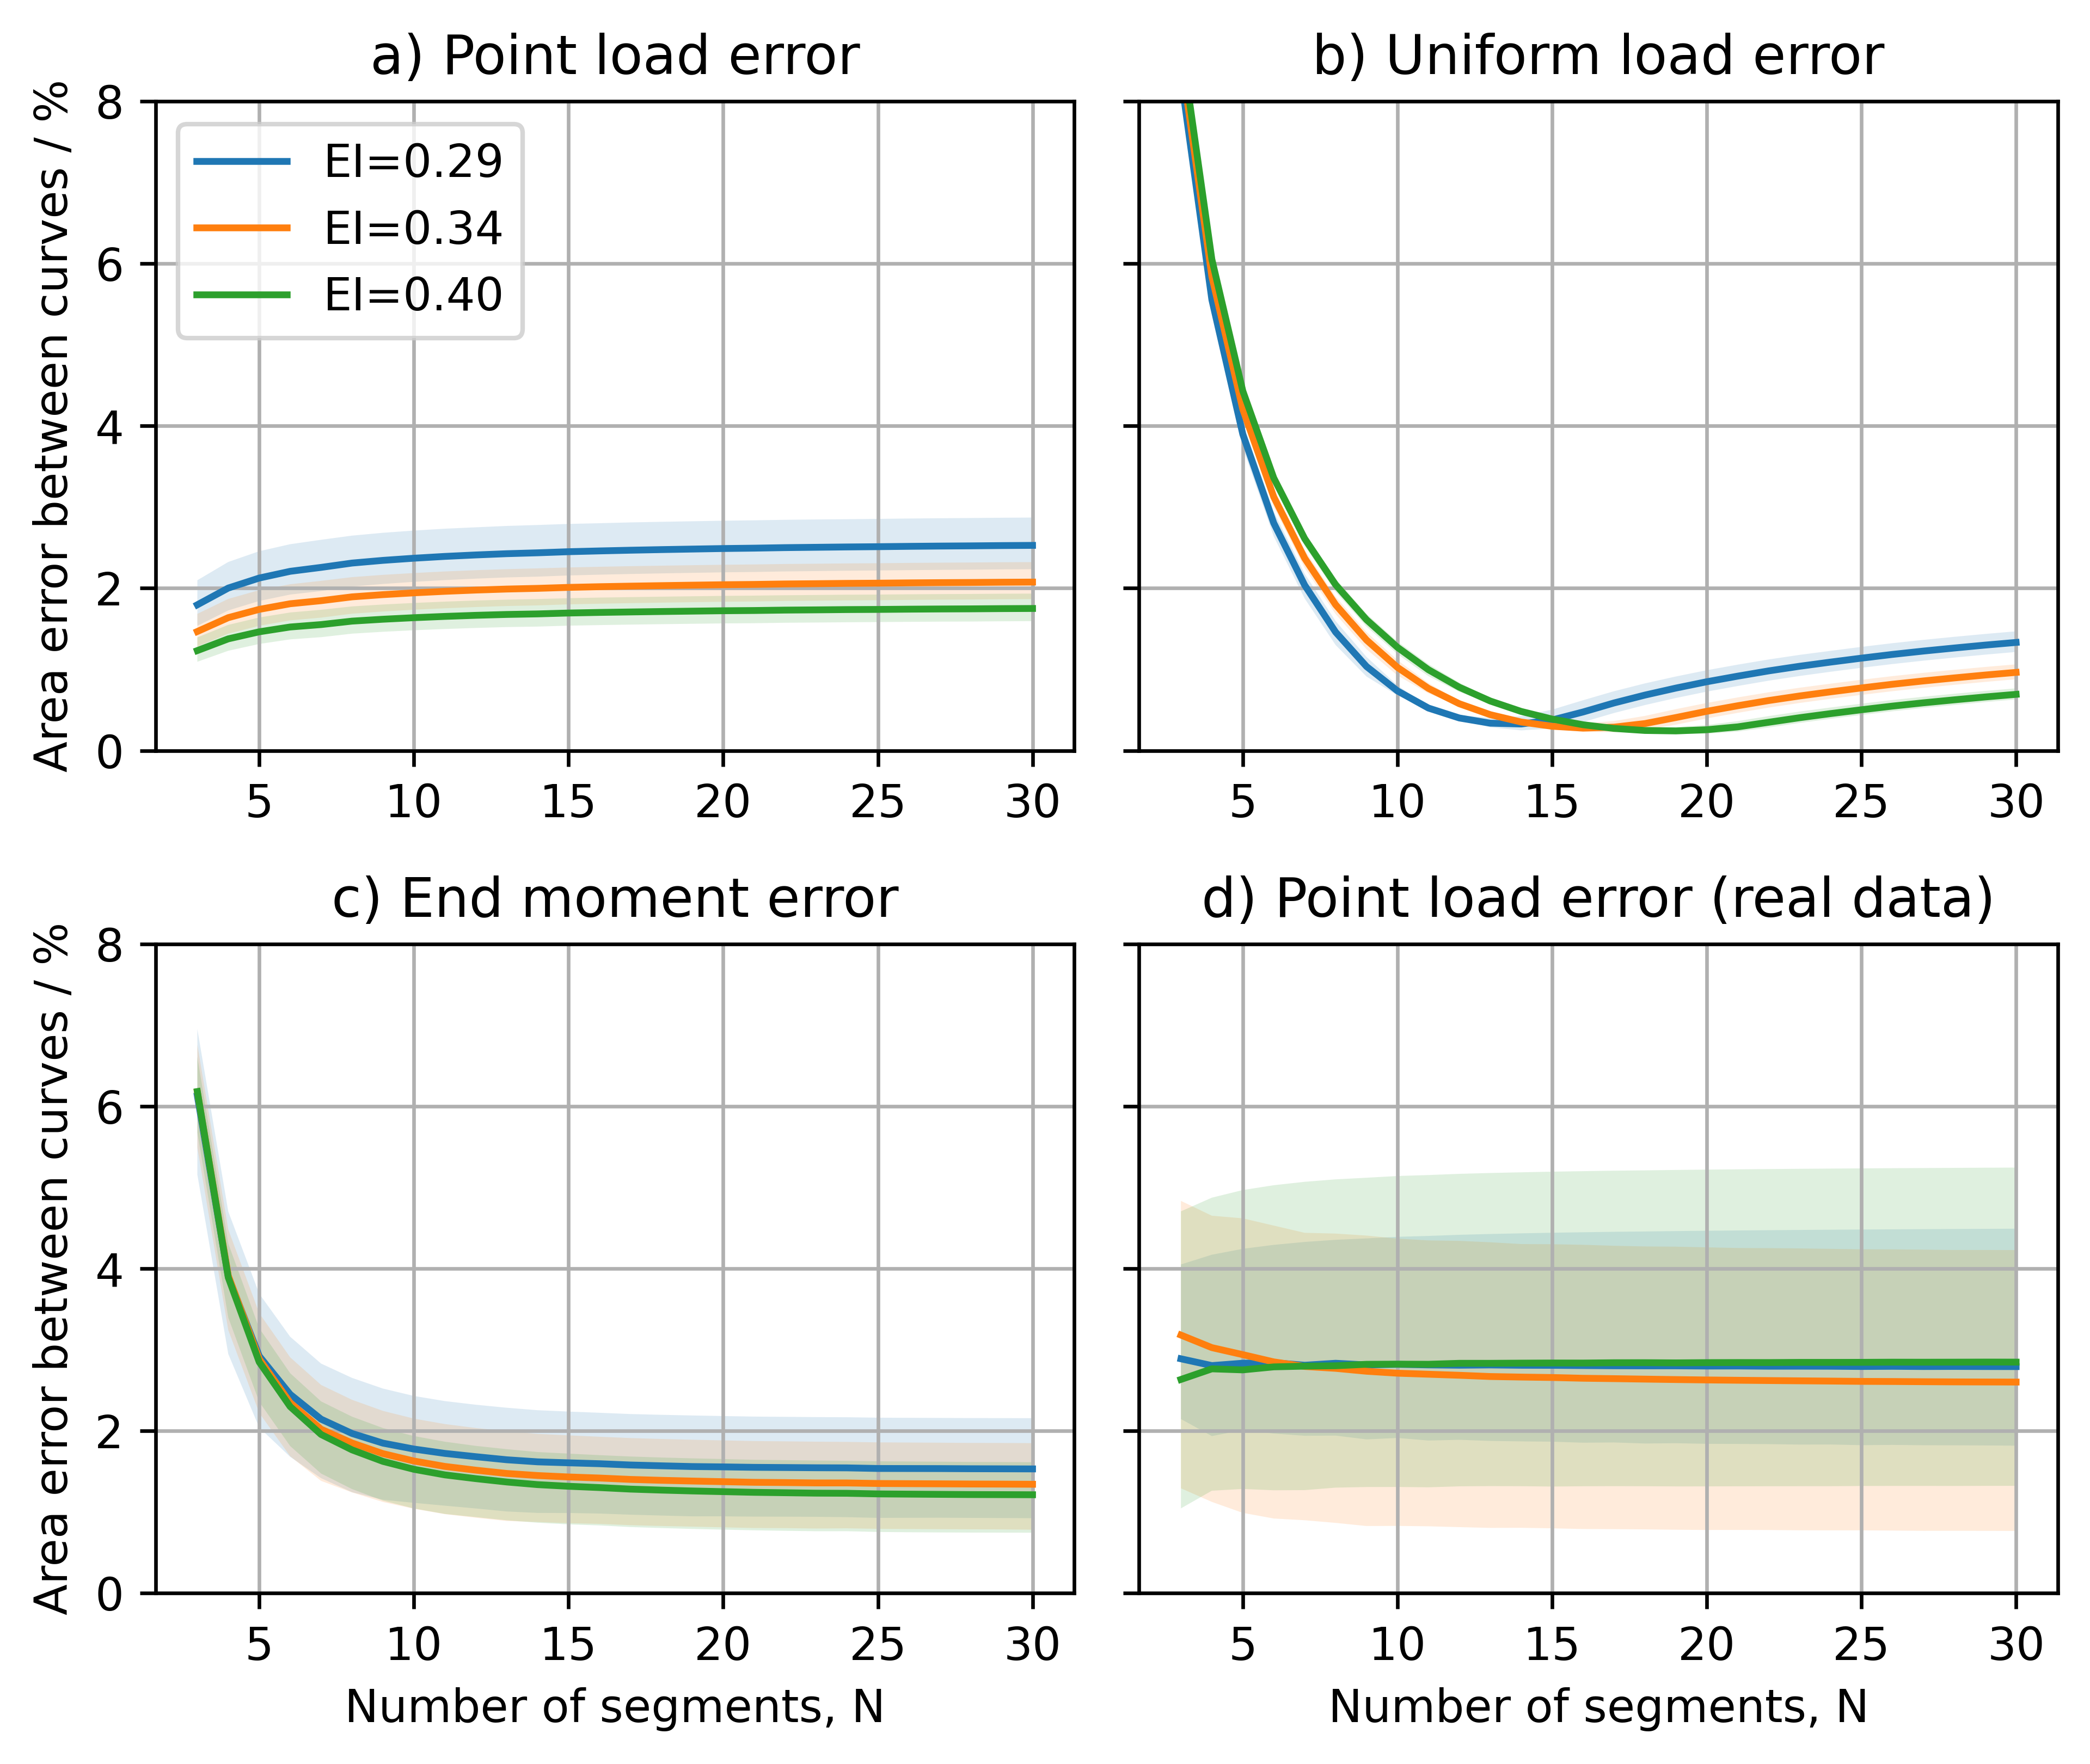

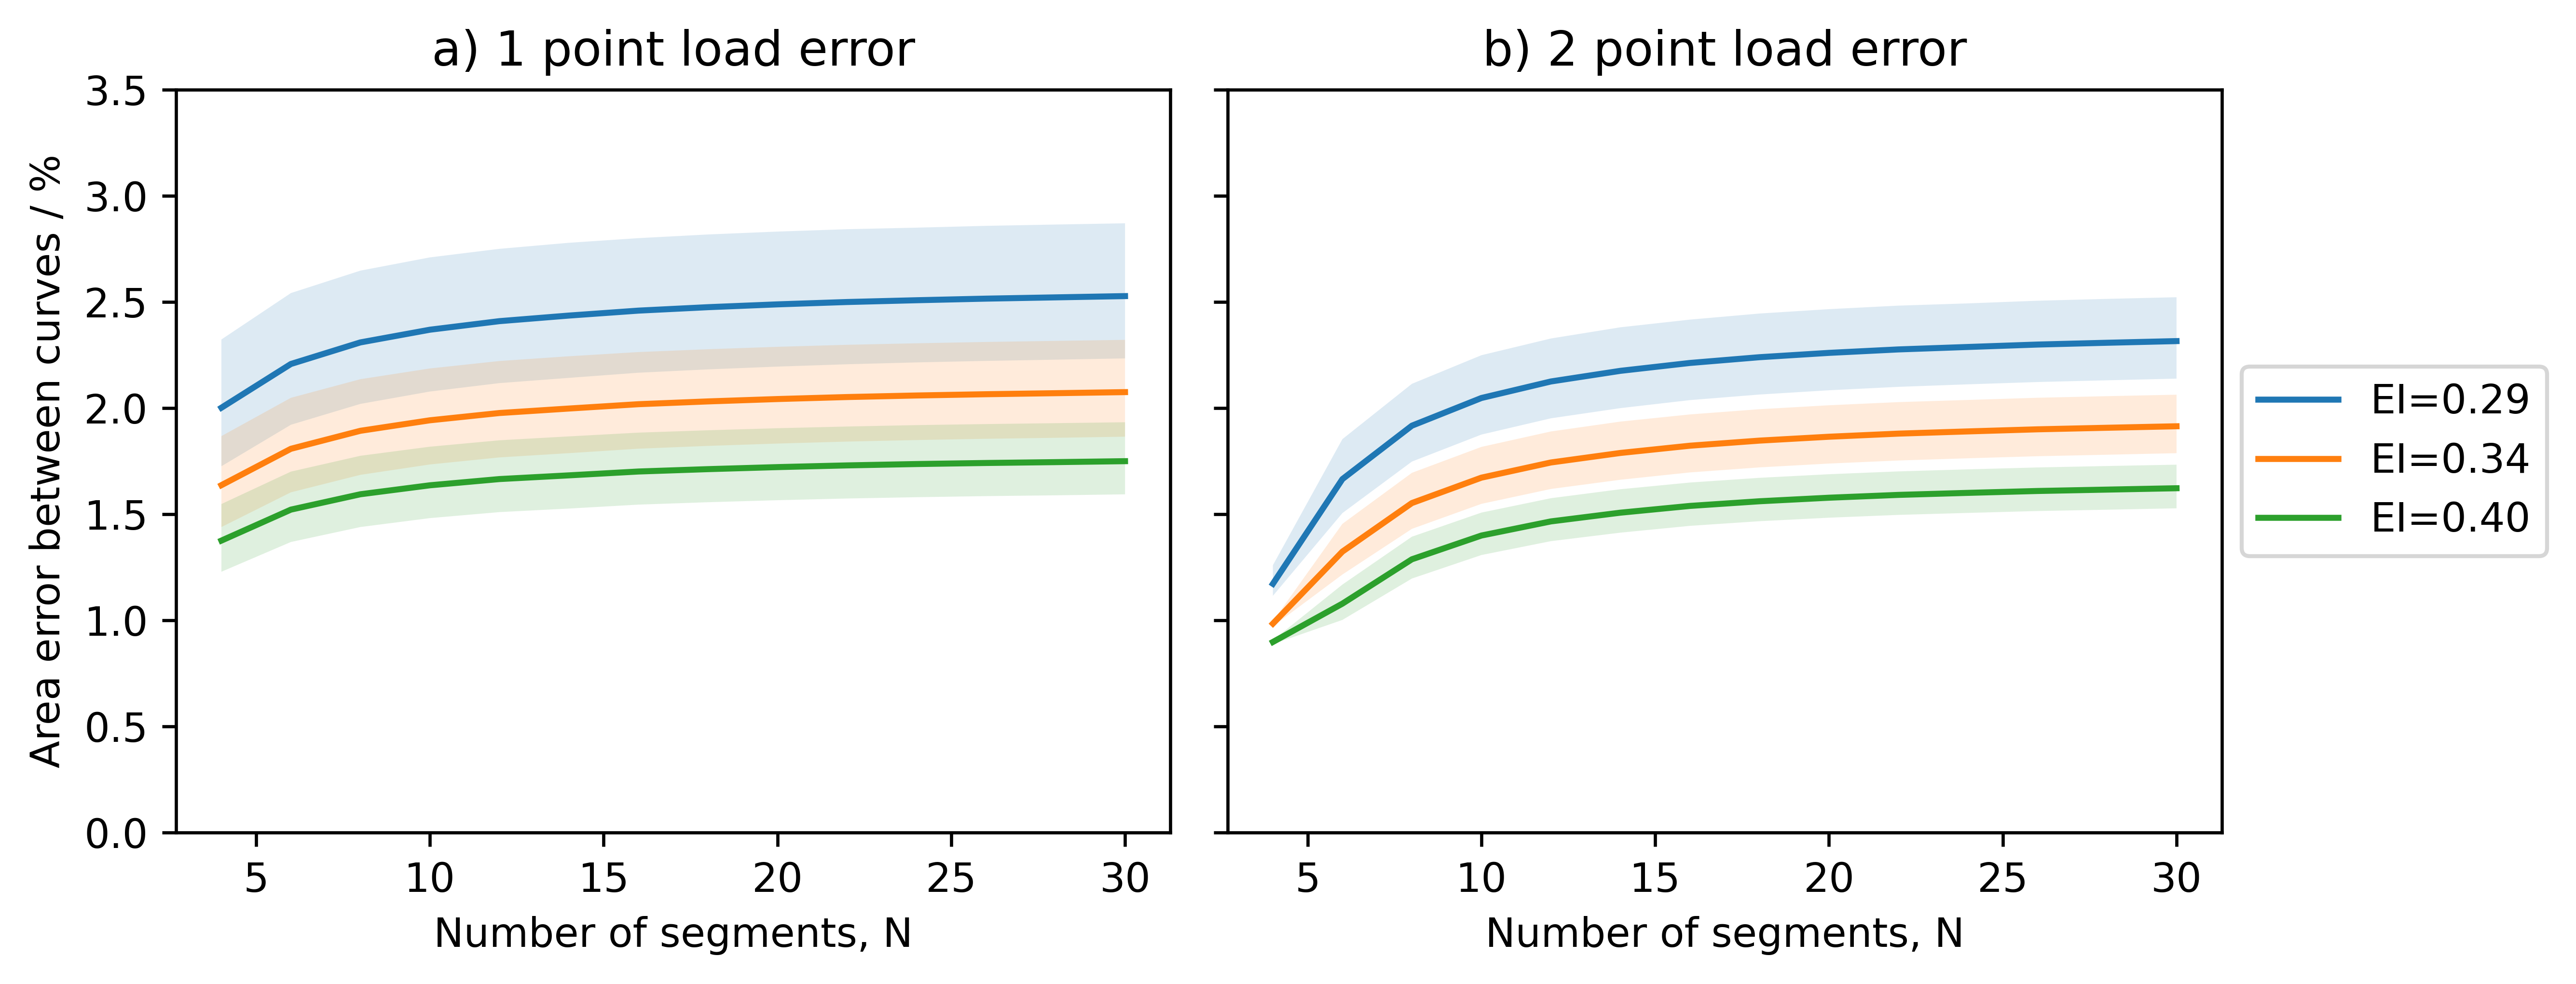

In [26]:
import pickle

multiplot = True
max_force = 3

save_suffix = "me"

name_style = "sim_data/sim_bending_E{0:.2f}_{1}{2}.pickle"

if multiplot:

  # point load
  with open(name_style.format(rigidities[0], "PL", save_suffix), "rb") as f:
    model_0p30_PL = pickle.load(f)

  with open(name_style.format(rigidities[1], "PL", save_suffix), "rb") as f:
    model_0p35_PL = pickle.load(f)

  with open(name_style.format(rigidities[2], "PL", save_suffix), "rb") as f:
    model_0p41_PL = pickle.load(f)

  # UDL
  with open(name_style.format(rigidities[0], "UDL", save_suffix), "rb") as f:
    model_0p30_UDL = pickle.load(f)

  with open(name_style.format(rigidities[1], "UDL", save_suffix), "rb") as f:
    model_0p35_UDL = pickle.load(f)

  with open(name_style.format(rigidities[2], "UDL", save_suffix), "rb") as f:
    model_0p41_UDL = pickle.load(f)

  # pure moment
  with open(name_style.format(rigidities[0], "EM", save_suffix), "rb") as f:
    model_0p30_EM = pickle.load(f)

  with open(name_style.format(rigidities[1], "EM", save_suffix), "rb") as f:
    model_0p35_EM = pickle.load(f)

  with open(name_style.format(rigidities[2], "EM", save_suffix), "rb") as f:
    model_0p41_EM = pickle.load(f)

  # 2 point loads, each P/2, one at midpoint, one at end
  with open(name_style.format(rigidities[0], "2PL", save_suffix), "rb") as f:
    model_0p30_2PL = pickle.load(f)

  with open(name_style.format(rigidities[1], "2PL", save_suffix), "rb") as f:
    model_0p35_2PL = pickle.load(f)

  with open(name_style.format(rigidities[2], "2PL", save_suffix), "rb") as f:
    model_0p41_2PL = pickle.load(f)

models_PL = [
  model_0p30_PL,
  model_0p35_PL,
  model_0p41_PL,
]

models_UDL = [
  model_0p30_UDL,
  model_0p35_UDL,
  model_0p41_UDL,
]

models_EM = [
  model_0p30_EM,
  model_0p35_EM,
  model_0p41_EM,
]

models_2PL = [
  model_0p30_2PL,
  model_0p35_2PL,
  model_0p41_2PL,
]

diff_labels = [
  "EI=0.29",
  "EI=0.34",
  "EI=0.40",
]

model_vs_UDL_titles = [
  "Point load error",
  "Uniform load error"
]

tuned_vs_UDL_titles = [
  "Tuned point load error",
  "tuned uniform load error"
]

all_loads_titles = [
  "Point load error",
  "Uniform load error",
  "End moment error",
  "Max error"
]

sim_and_real_loads_titles = [
  "Point load error",
  "Uniform load error",
  "End moment error",
  "Point load error (real data)"
]

# set to a value from 0->1.0 to fill errors with that transparency
fill_alpha = 0.15
max_force = 3
print_k = False
k_print_max = False # if true, print maximums, if false print means

# MAIN PLOT area error: plot theory x3 and real data all in one
if True:
  # area error plot
  plot_avg_errors(models_PL + models_UDL + models_EM, diff_labels, joint_percent=True, joint_plot=3,
                  tip_plot=False, titles=sim_and_real_loads_titles, sharey=True, difference_plot=False,
                  prediction_plot=False, multiplot_num=len(models_PL), absolute_error=True, max_plot=False,
                  fill_errors=fill_alpha, real_tip=False, area_error=True, grid=True, k_print_max=k_print_max,
                  real_data=real_data, min_force=1, print_k=print_k, square_plot=True,
                  plot_ylims=[0, 8]) # print_k prints detailed max errors
  
# tip error plot
if False:
  plot_avg_errors(models_PL + models_UDL + models_EM, diff_labels, joint_percent=False, joint_plot=False,
                  tip_plot=3, titles=sim_and_real_loads_titles, sharey=True, difference_plot=False,
                  prediction_plot=False, multiplot_num=len(models_PL), absolute_error=True, max_plot=False,
                  fill_errors=fill_alpha, real_tip=True, area_error=False, grid=True, k_print_max=k_print_max,
                  real_data=real_data, min_force=1, print_k=print_k, square_plot=True,
                  plot_ylims=[0, 8]) # print_k prints detailed max errors

# max plot
if False:
  max_labels = None# ["All forces", "Forces averaged"]
  plot_avg_errors(models_PL + models_UDL + models_EM, max_labels, tip_percent=False, joint_percent=True, joint_plot=False,
                  prediction_plot=False, multiplot_num=len(models_PL), absolute_error=True, max_plot=3, area_error=True,
                  print_k=print_k, min_force=1, tip_plot=False, grid=True) # 3 means PL, UDL, and EM
  
# examine 2 point loads, to answer reviewer comments
if True:
  even_PL = [[], [], []]
  even_2PL = [[], [], []]
  for i in range(len(models_PL[0])):
    if i % 2 == 1:
      for j in range(3):
        even_PL[j].append(models_PL[j][i])
        even_2PL[j].append(models_2PL[j][i])
  plot_avg_errors(even_PL + even_2PL, diff_labels, joint_percent=True, joint_plot=2,
                  tip_plot=False, titles=["1 point load error", "2 point load error"], sharey=True, difference_plot=False,
                  prediction_plot=False, multiplot_num=len(models_2PL), absolute_error=True, max_plot=False,
                  fill_errors=fill_alpha, real_tip=False, area_error=True, grid=False, k_print_max=k_print_max,
                  real_data=None, min_force=1, print_k=print_k, square_plot=False,
                  plot_ylims=[0, 3.5]) # print_k prints detailed max errors


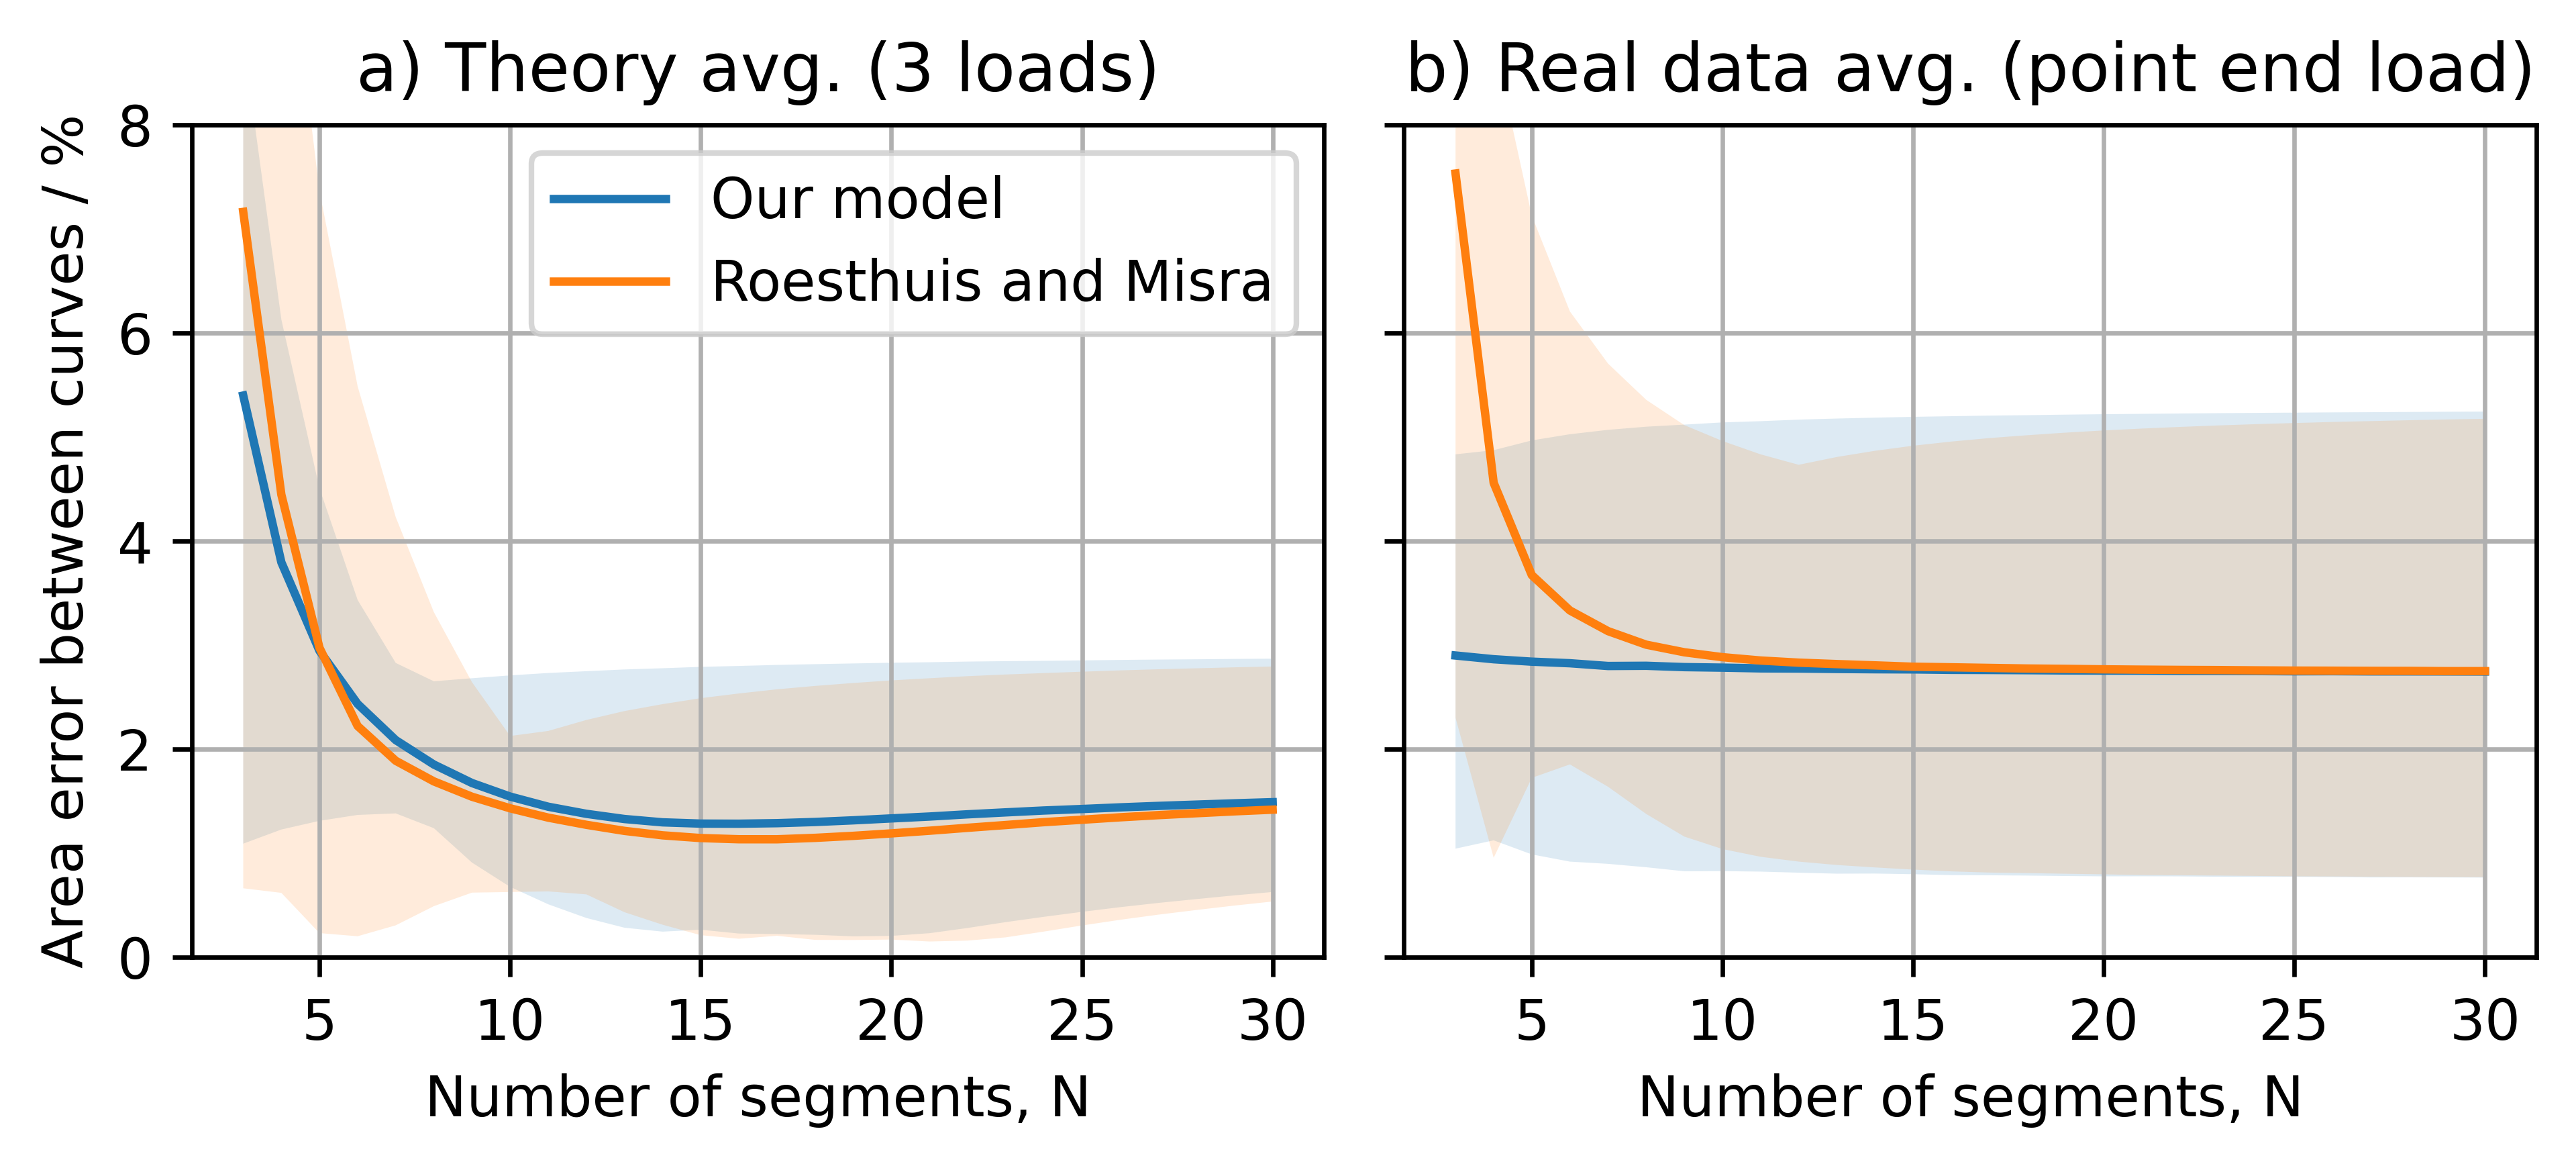

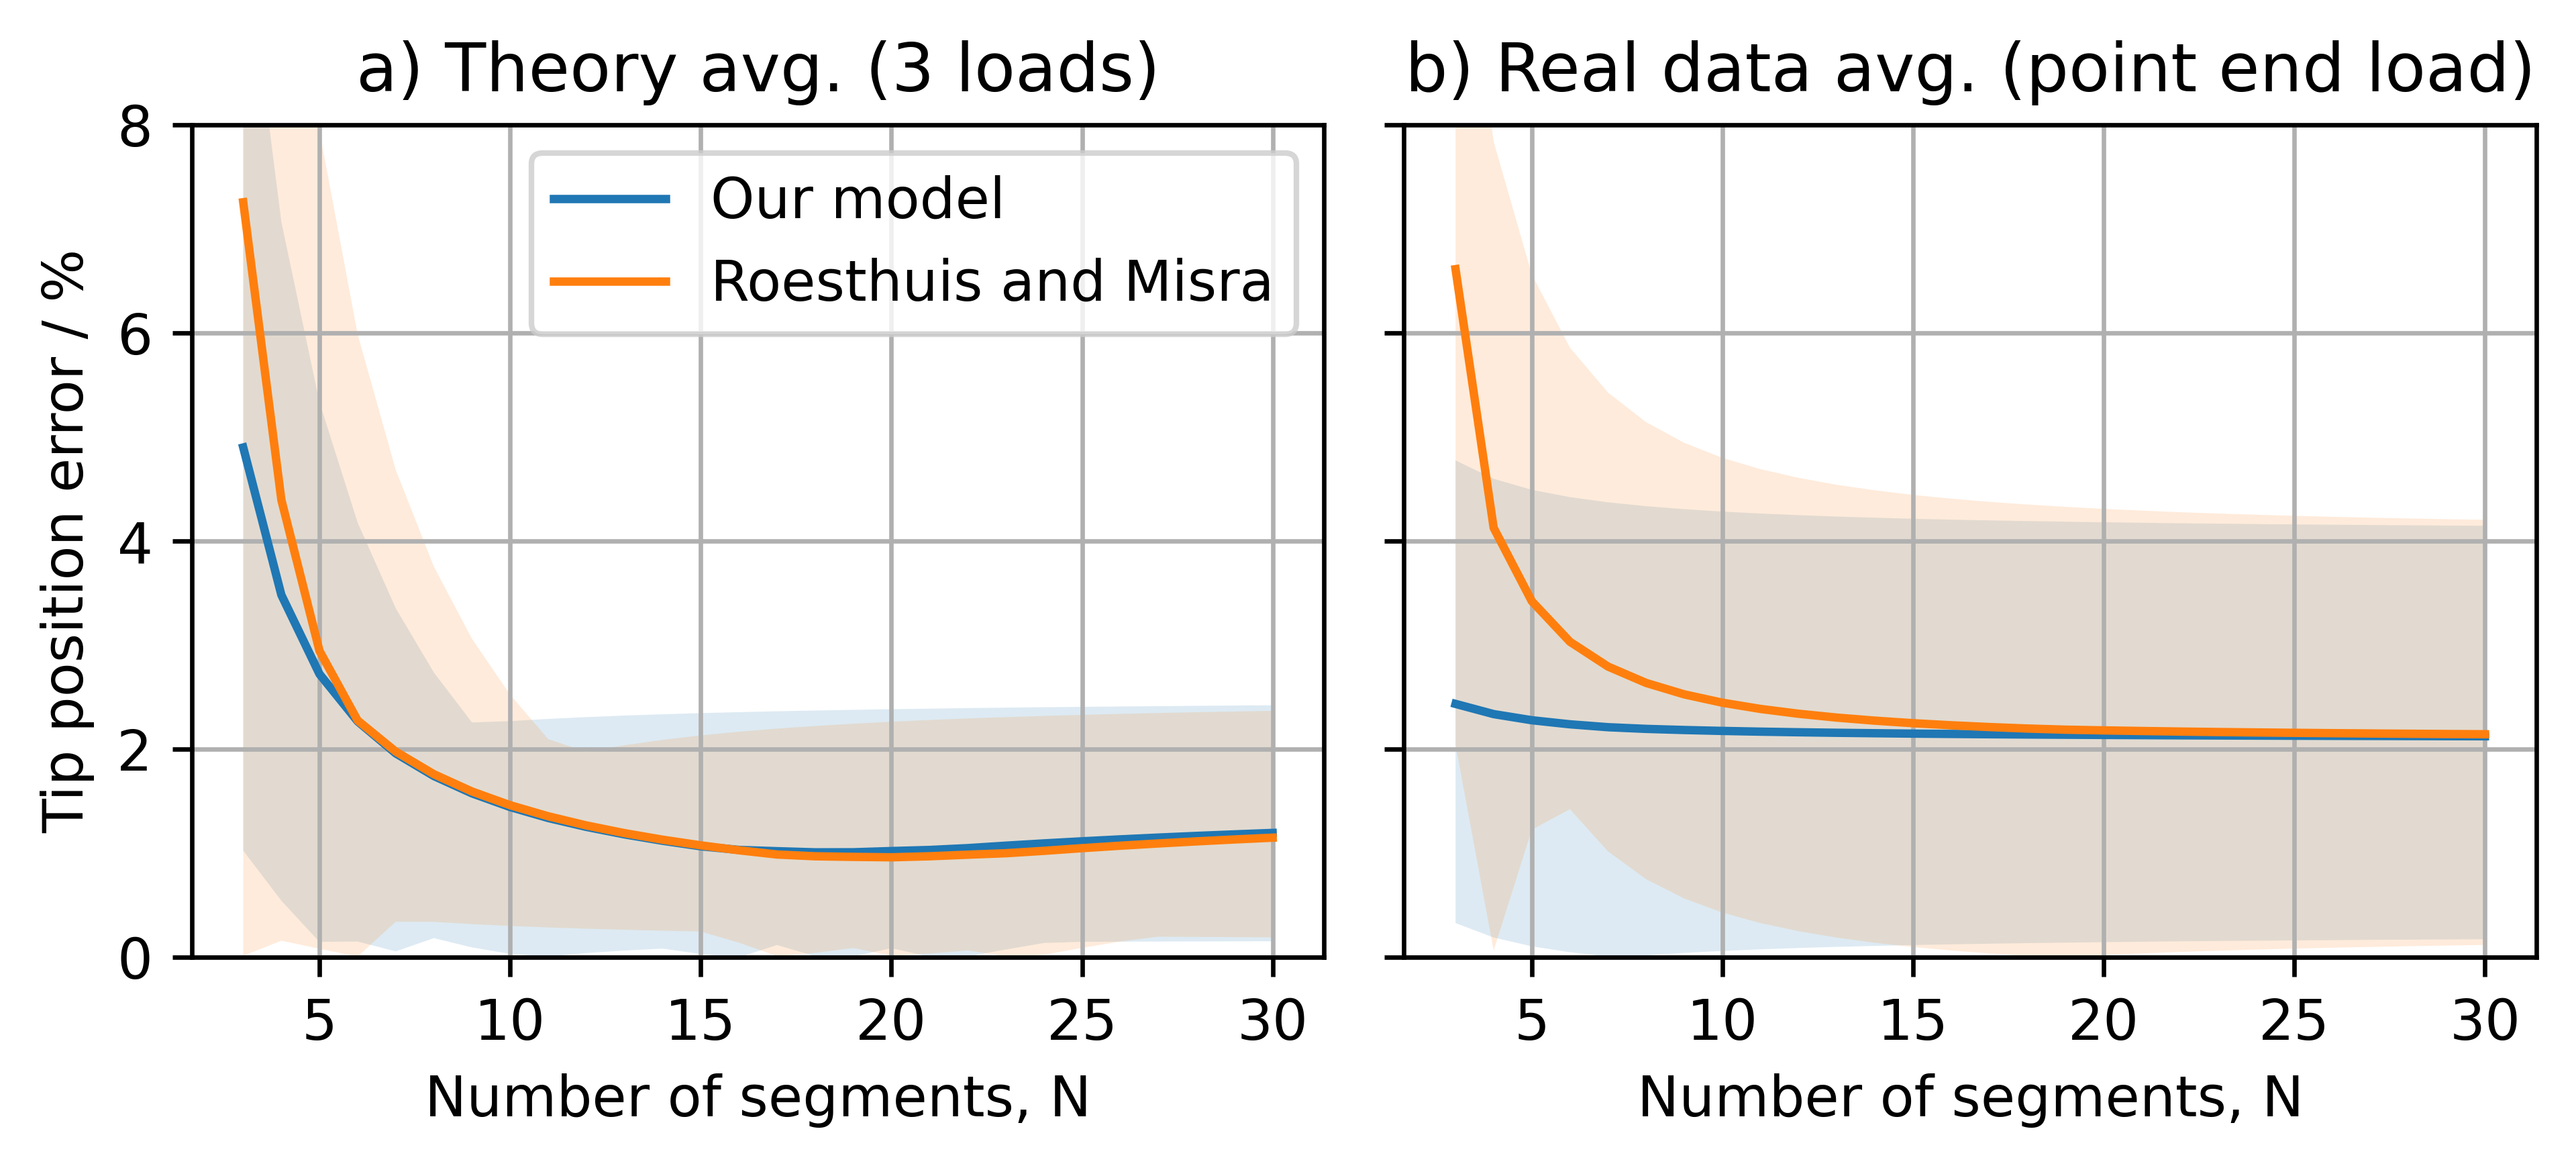

In [27]:
name_style = "sim_data/sim_bending_E{0:.2f}_{1}{2}.pickle"

save_suffix = "paper"

if multiplot:

  # point load
  with open(name_style.format(rigidities[0], "PL", save_suffix), "rb") as f:
    model_0p30_PL_paper = pickle.load(f)

  with open(name_style.format(rigidities[1], "PL", save_suffix), "rb") as f:
    model_0p35_PL_paper = pickle.load(f)

  with open(name_style.format(rigidities[2], "PL", save_suffix), "rb") as f:
    model_0p41_PL_paper = pickle.load(f)

  # UDL
  with open(name_style.format(rigidities[0], "UDL", save_suffix), "rb") as f:
    model_0p30_UDL_paper = pickle.load(f)

  with open(name_style.format(rigidities[1], "UDL", save_suffix), "rb") as f:
    model_0p35_UDL_paper = pickle.load(f)

  with open(name_style.format(rigidities[2], "UDL", save_suffix), "rb") as f:
    model_0p41_UDL_paper = pickle.load(f)

  # pure moment
  with open(name_style.format(rigidities[0], "EM", save_suffix), "rb") as f:
    model_0p30_EM_paper = pickle.load(f)

  with open(name_style.format(rigidities[1], "EM", save_suffix), "rb") as f:
    model_0p35_EM_paper = pickle.load(f)

  with open(name_style.format(rigidities[2], "EM", save_suffix), "rb") as f:
    model_0p41_EM_paper = pickle.load(f)

  # 2 point loads, each P/2, one at midpoint, one at end
  with open(name_style.format(rigidities[0], "2PL", save_suffix), "rb") as f:
    model_0p30_2PL_paper = pickle.load(f)

  with open(name_style.format(rigidities[1], "2PL", save_suffix), "rb") as f:
    model_0p35_2PL_paper = pickle.load(f)

  with open(name_style.format(rigidities[2], "2PL", save_suffix), "rb") as f:
    model_0p41_2PL_paper = pickle.load(f)

models_PL_paper = [
  model_0p30_PL_paper,
  model_0p35_PL_paper,
  model_0p41_PL_paper,
]

models_UDL_paper = [
  model_0p30_UDL_paper,
  model_0p35_UDL_paper,
  model_0p41_UDL_paper,
]

models_EM_paper = [
  model_0p30_EM_paper,
  model_0p35_EM_paper,
  model_0p41_EM_paper,
]


models_2PL_paper = [
  model_0p30_2PL_paper,
  model_0p35_2PL_paper,
  model_0p41_2PL_paper,
]

diff_labels = [
  "Our model",
  "Roesthuis and Misra"
]

# set to a value from 0->1.0 to fill errors with that transparency
fill_alpha = 0.15
max_force = 3
print_k = False
k_print_max = False # if true, print maximums, if false print means

themodels = models_PL + models_PL_paper + models_UDL + models_UDL_paper + models_EM + models_EM_paper

# plot comparison between my method and the paper
if False:
  # area error
  plot_avg_errors(themodels, diff_labels, joint_percent=True, joint_plot=3,
                  tip_plot=False, titles=sim_and_real_loads_titles, sharey=True, difference_plot=False,
                  prediction_plot=False, multiplot_num=6, absolute_error=True, max_plot=False,
                  fill_errors=fill_alpha, real_tip=False, area_error=True, grid=True, k_print_max=k_print_max,
                  real_data=real_data, min_force=1, print_k=print_k, square_plot=True,
                  plot_ylims=[0, 8], do_method_compare=True,
                  fingernums=[1,1,1,1,1,1]) # print_k prints detailed max errors
  
if True:
  # area error, all of theory averaged
  averaged_titles = ["Theory avg. (3 loads)", "Real data avg. (point end load)"]
  plot_avg_errors(themodels, diff_labels, joint_percent=True, joint_plot=1,
                  tip_plot=False, titles=averaged_titles, sharey=True, difference_plot=False,
                  prediction_plot=False, multiplot_num=6, absolute_error=True, max_plot=False,
                  fill_errors=fill_alpha, real_tip=False, area_error=True, grid=True, k_print_max=k_print_max,
                  real_data=real_data, min_force=1, print_k=print_k, square_plot=False,
                  plot_ylims=[0, 8], do_method_compare=True, average_all_theory=True,
                  fingernums=[1,1,1,1,1,1]) # print_k prints detailed max errors
  
if False:
  # tip error
  plot_avg_errors(themodels, diff_labels, joint_percent=False, joint_plot=False,
                  tip_plot=3, titles=sim_and_real_loads_titles, sharey=True, difference_plot=False,
                  prediction_plot=False, multiplot_num=6, absolute_error=True, max_plot=False,
                  fill_errors=fill_alpha, real_tip=True, area_error=False, grid=True, k_print_max=k_print_max,
                  real_data=real_data, min_force=1, print_k=print_k, square_plot=True,
                  plot_ylims=[0, 8], do_method_compare=True,
                  fingernums=[1,1,1,1,1,1]) # print_k prints detailed max errors
  
if True:
  # tip error, all of theory averaged
  averaged_titles = ["Theory avg. (3 loads)", "Real data avg. (point end load)"]
  plot_avg_errors(themodels, diff_labels, joint_percent=True, joint_plot=False,
                  tip_plot=1, titles=averaged_titles, sharey=True, difference_plot=False,
                  prediction_plot=False, multiplot_num=6, absolute_error=True, max_plot=False,
                  fill_errors=fill_alpha, real_tip=True, area_error=False, grid=True, k_print_max=k_print_max,
                  real_data=real_data, min_force=1, print_k=print_k, square_plot=False,
                  plot_ylims=[0, 8], do_method_compare=True, average_all_theory=True,
                  fingernums=[1,1,1,1,1,1]) # print_k prints detailed max errors
  
# examine 2 point loads, to answer reviewer comments
if False:
  even_2PL = [[], [], []]
  even_2PL_paper = [[], [], []]
  for i in range(len(models_2PL[0])):
    if i % 2 == 1:
      for j in range(3):
        even_2PL[j].append(models_2PL[j][i])
        even_2PL_paper[j].append(models_2PL_paper[j][i])
  plot_avg_errors(even_2PL + even_2PL_paper, diff_labels, joint_percent=True, joint_plot=2,
                  tip_plot=False, titles=["1 point load error", "2 point load error"], sharey=True, difference_plot=False,
                  prediction_plot=False, multiplot_num=len(models_2PL), absolute_error=True, max_plot=False,
                  fill_errors=fill_alpha, real_tip=False, area_error=True, grid=False, k_print_max=k_print_max,
                  real_data=None, min_force=1, print_k=print_k, square_plot=False,
                  plot_ylims=[0, 7.5]) # print_k prints detailed max errors

In [28]:

# ----- old plots ----- #

# # all three load conditions area error plot
# plot_avg_errors(models_PL + models_UDL + models_EM, diff_labels, joint_percent=True, joint_plot=3,
#                 tip_plot=False, titles=all_loads_titles, sharey=True, difference_plot=False,
#                 prediction_plot=False, multiplot_num=len(models_PL), absolute_error=True, max_plot=False,
#                 fill_errors=fill_alpha, area_error=True, print_k=True) # print_k prints detailed max errors

# all three load conditions avg. joint error plot
# plot_avg_errors(models_PL + models_UDL + models_EM, diff_labels, joint_percent=True, joint_plot=3,
#                 tip_plot=False, titles=all_loads_titles, sharey=True, difference_plot=False,
#                 prediction_plot=False, multiplot_num=len(all_models), absolute_error=True, max_error=True,
#                 fill_errors=fill_alpha)

# # all three load conditions tip error plot
# plot_avg_errors(models_PL + models_UDL + models_EM, diff_labels, tip_percent=True, joint_plot=False,
#                 tip_plot=3, titles=all_loads_titles, sharey=True, difference_plot=False,
#                 prediction_plot=False, multiplot_num=len(models_PL), absolute_error=True, max_plot=False,
#                 fill_errors=fill_alpha)

# # max plot
# max_labels = ["All forces", "Forces averaged"]
# plot_avg_errors(models_PL + models_UDL + models_EM, max_labels, tip_percent=False, joint_percent=True, joint_plot=False,
#                 prediction_plot=False, multiplot_num=len(models_PL), absolute_error=True, max_plot=3, area_error=True,
#                 print_k=True, min_force=1, tip_plot=False) # 3 means PL, UDL, and EM

# # multiple loads in one plot
# ind = 2
# datatest = [models_PL[ind]] + [models_UDL[ind]] + [models_EM[ind]]
# plot_errors(datatest, plot="tip", y_vs_pred=False, y_vs_theory=True, pred_vs_theory=False, percent=True, 
#             sharey=False, absolute_error=True, plot_avg=False, all_loads_plot=True, titles_override=all_loads_titles)

# plotting all the real errors on one plot
# plot_avg_errors(models_PL[1:-1], diff_labels[1:-1], tip_percent=True, real_data=real_data,
#                 joint_plot=False, tip_plot=False, max_error=False, fill_errors=fill_alpha, real_tip=True)
# plot_avg_errors(models_PL[1:-1], diff_labels[1:-1], tip_percent=True, real_data=real_data,
#                 joint_plot=False, tip_plot=False, max_error=False, fill_errors=fill_alpha, real_tip=False)
# plot_avg_errors(models_PL[1:-1], diff_labels[1:-1], tip_percent=False, real_data=real_data,
#                 joint_plot=False, tip_plot=False, max_error=False, fill_errors=fill_alpha, real_tip=False, area_error=True)
# plot_avg_errors(models_PL, diff_labels, tip_percent=False, real_data=real_data,
#                 joint_plot=False, tip_plot=False, max_error=False, fill_errors=fill_alpha, real_tip=False, area_error=True)

# reapeat 4x plot only with 300g errors included
# plot_avg_errors(models_PL + models_UDL + models_EM, diff_labels, joint_percent=True, joint_plot=3,
#                 tip_plot=False, titles=sim_and_real_loads_titles, sharey=True, difference_plot=False,
#                 prediction_plot=False, multiplot_num=len(models_PL), absolute_error=True, max_plot=False,
#                 fill_errors=fill_alpha, real_tip=False, area_error=True,
#                 real_data=real_data, min_force=3)
# plot_avg_errors(models_PL + models_UDL + models_EM, diff_labels, joint_percent=True, joint_plot=3,
#                 tip_plot=False, titles=sim_and_real_loads_titles, sharey=True, difference_plot=False,
#                 prediction_plot=False, multiplot_num=len(models_PL), absolute_error=True, max_plot=False,
#                 fill_errors=fill_alpha, real_tip=False, area_error=True,
#                 real_data=real_data, min_force=3, fingernums="all")
# plot_avg_errors(models_PL + models_UDL + models_EM, diff_labels, joint_percent=True, joint_plot=3,
#                 tip_plot=False, titles=sim_and_real_loads_titles, sharey=True, difference_plot=False,
#                 prediction_plot=False, multiplot_num=len(models_PL), absolute_error=True, max_plot=False,
#                 fill_errors=fill_alpha, real_tip=False, area_error=True,
#                 real_data=real_data, min_force=2, fingernums="all")

# plot_avg_errors(models_PL + models_UDL + models_EM, diff_labels, joint_percent=True, joint_plot=3,
#                 tip_plot=False, titles=sim_and_real_loads_titles, sharey=True, difference_plot=False,
#                 prediction_plot=False, multiplot_num=len(models_PL), absolute_error=True, max_plot=False,
#                 fill_errors=fill_alpha, real_tip=False, area_error=True,
#                 real_data=real_data, min_force=3, fingernums=[1, 1, 1])
# plot_avg_errors(models_PL + models_UDL + models_EM, diff_labels, joint_percent=True, joint_plot=3,
#                 tip_plot=False, titles=sim_and_real_loads_titles, sharey=True, difference_plot=False,
#                 prediction_plot=False, multiplot_num=len(models_PL), absolute_error=True, max_plot=False,
#                 fill_errors=fill_alpha, real_tip=False, area_error=True,
#                 real_data=real_data, min_force=3, fingernums=[2, 2, 2])
# plot_avg_errors(models_PL + models_UDL + models_EM, diff_labels, joint_percent=True, joint_plot=3,
#                 tip_plot=False, titles=sim_and_real_loads_titles, sharey=True, difference_plot=False,
#                 prediction_plot=False, multiplot_num=len(models_PL), absolute_error=True, max_plot=False,
#                 fill_errors=fill_alpha, real_tip=False, area_error=True,
#                 real_data=real_data, min_force=3, fingernums=[3, 3, 3])